# Dependencies loading

In [940]:
import pandas as pd # Standard
import numpy as np # Standard
from datetime import datetime # Date and Time
from pandas_datareader import data as pdr # to import data from FRED

import seaborn as sns # Data Visualization
import matplotlib.pyplot as plt # Data Visualization
from matplotlib.ticker import FuncFormatter, LogLocator # Data Visualization
import plotly.express as px # Data Visualization
from scipy.stats.mstats import winsorize

import statsmodels.api as sm # Statistics
import statsmodels.tsa.api as tsa # Statistics
from scipy.stats import norm, skew, kurtosis, shapiro, binom_test # Statistics
from scipy.optimize import minimize # Statistics
from statsmodels.tsa.stattools import adfuller # Statistics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Statistics

from arch import arch_model # TS
from sklearn.preprocessing import StandardScaler

In [941]:
import warnings
warnings.filterwarnings("ignore")

# Data preparation

## Data loading

In [942]:
BTC_url = 'https://raw.githubusercontent.com/IlyaSshnip/RR_project/main/Bitcoin_daily.csv'
SP500_url = 'https://raw.githubusercontent.com/IlyaSshnip/RR_project/main/S&P500.csv'
TMUBMUSD01Y_url = 'https://raw.githubusercontent.com/IlyaSshnip/RR_project/main/TMUBMUSD01Y.csv'

df_BTC = pd.read_csv(BTC_url)
df_BTC.columns = df_BTC.columns.str.strip()

df_SP500 = pd.read_csv(SP500_url)
df_SP500.columns = df_SP500.columns.str.strip()

df_TMUBMUSD01Y = pd.read_csv(TMUBMUSD01Y_url)
df_TMUBMUSD01Y.columns = df_TMUBMUSD01Y.columns.str.strip()

start=datetime(2014, 5, 1)
end=datetime(2024, 5, 1)

# Macroeconomic Indicators (from FRED):

UN_Rate = pdr.get_data_fred('UNRATE', start, end) # Unemployment Rate
Real_GDP = pdr.get_data_fred('A191RL1Q225SBEA', start, end) # Real GDP
CPI = pdr.get_data_fred('CPIAUCSL', start, end) # Consumer Price Index
VIX = pdr.get_data_fred('VIXCLS', start, end) # Volatility Index
Ten_Year_Treasury_Yield = pdr.get_data_fred('DGS10', start, end) # 10-Year Treasury Yield
Federal_Funds_Rate = pdr.get_data_fred('FEDFUNDS', start, end) # Federal Funds Rate
BBB_Credit_Spread = pdr.get_data_fred('BAMLC0A4CBBB', start, end) # BBB Credit Spread

# print(df_BTC.head())
# print(df_SP500.head())
# print(df_TMUBMUSD01Y.head())
# print(UN_Rate.head())
# print(Real_GDP.head())
# print(CPI.head())
# print(VIX.head())
# print(Ten_Year_Treasury_Yield.head())
# print(Federal_Funds_Rate.head())
# print(BBB_Credit_Spread.head())

## Dataset adjustment

In [943]:
# Select Columns
df_SP500 = df_SP500[['Date', 'Close']].rename(columns={'Close': 'Price'})
df_BTC = df_BTC[['Date', 'Price']]
df_TMUBMUSD01Y = df_TMUBMUSD01Y[['Date', 'Close']].rename(columns={'Close': 'Price'})

########################################################################################

# Define Price as 'numeric'

df_SP500['Price'] = df_SP500['Price'].astype(str)
df_BTC['Price'] = df_BTC['Price'].astype(str)
df_TMUBMUSD01Y['Price'] = df_TMUBMUSD01Y['Price'].astype(str)

df_SP500['Price'] = pd.to_numeric(df_SP500['Price'].str.replace(',', ''), errors='coerce')
df_BTC['Price'] = pd.to_numeric(df_BTC['Price'].str.replace(',', ''), errors='coerce')
df_TMUBMUSD01Y['Price'] = pd.to_numeric(df_TMUBMUSD01Y['Price'].str.replace(',', ''), errors='coerce')

########################################################################################

# Date
df_SP500['Date'] = pd.to_datetime(df_SP500['Date'])
df_SP500.set_index('Date', inplace=True)

df_BTC['Date'] = pd.to_datetime(df_BTC['Date'])
df_BTC.set_index('Date', inplace=True)

df_TMUBMUSD01Y['Date'] = pd.to_datetime(df_TMUBMUSD01Y['Date'])
df_TMUBMUSD01Y.set_index('Date', inplace=True)

# Sort by Date
df_SP500.sort_index(inplace=True)
df_BTC.sort_index(inplace=True)
df_TMUBMUSD01Y.sort_index(inplace=True)

df_SP500 = df_SP500.loc[start:end]
df_BTC = df_BTC.loc[start:end] # Cryptocurrency market is open on weekends
df_TMUBMUSD01Y = df_TMUBMUSD01Y.loc[start:end]

########################################################################################

# print(df_SP500.head())
# print(df_SP500.tail()) 
# print(df_TMUBMUSD01Y.head())
# print(df_TMUBMUSD01Y.tail())
# print(df_BTC.tail())

## Returns calculation (Daily)

In [944]:
df_SP500['Return'] = df_SP500['Price'].pct_change() 
df_BTC['Return'] = df_BTC['Price'].pct_change() 
df_TMUBMUSD01Y['Return'] = df_TMUBMUSD01Y['Price'].pct_change() 

In [945]:
# print(df_SP500.head())
# print(df_TMUBMUSD01Y.head())
# print(df_BTC.head())

# Exploratory Data Analysis

## Summary Statistics

In [946]:
print(df_SP500.describe())
print(df_BTC.describe())
print(df_TMUBMUSD01Y.describe())

             Price       Return
count  2517.000000  2516.000000
mean   3110.347695     0.000454
std     944.565837     0.011169
min    1829.079956    -0.119841
25%    2180.389893    -0.003781
50%    2859.530029     0.000596
75%    3992.929932     0.005679
max    5254.350098     0.093828
              Price       Return
count   3654.000000  3653.000000
mean   15441.343240     0.002015
std    17693.556835     0.036929
min      164.900000    -0.391816
25%      704.375000    -0.012352
50%     8186.000000     0.001205
75%    26251.075000     0.017021
max    73066.300000     0.272286
             Price       Return
count  2536.000000  2535.000000
mean      1.658946     0.013124
std       1.700777     0.389819
min       0.005000    -0.934211
25%       0.214000    -0.011437
50%       1.068000     0.000000
75%       2.450500     0.012862
max       5.515000    14.200000


## Check for Missing Values

In [947]:
print(df_SP500.isnull().sum())
print(df_BTC.isnull().sum())
print(df_TMUBMUSD01Y.isnull().sum())

Price     0
Return    1
dtype: int64
Price     0
Return    1
dtype: int64
Price     0
Return    1
dtype: int64


## Price Changes of the S&P 500 Index, Bitcoin, and the 1-Year U.S. Treasury Bond

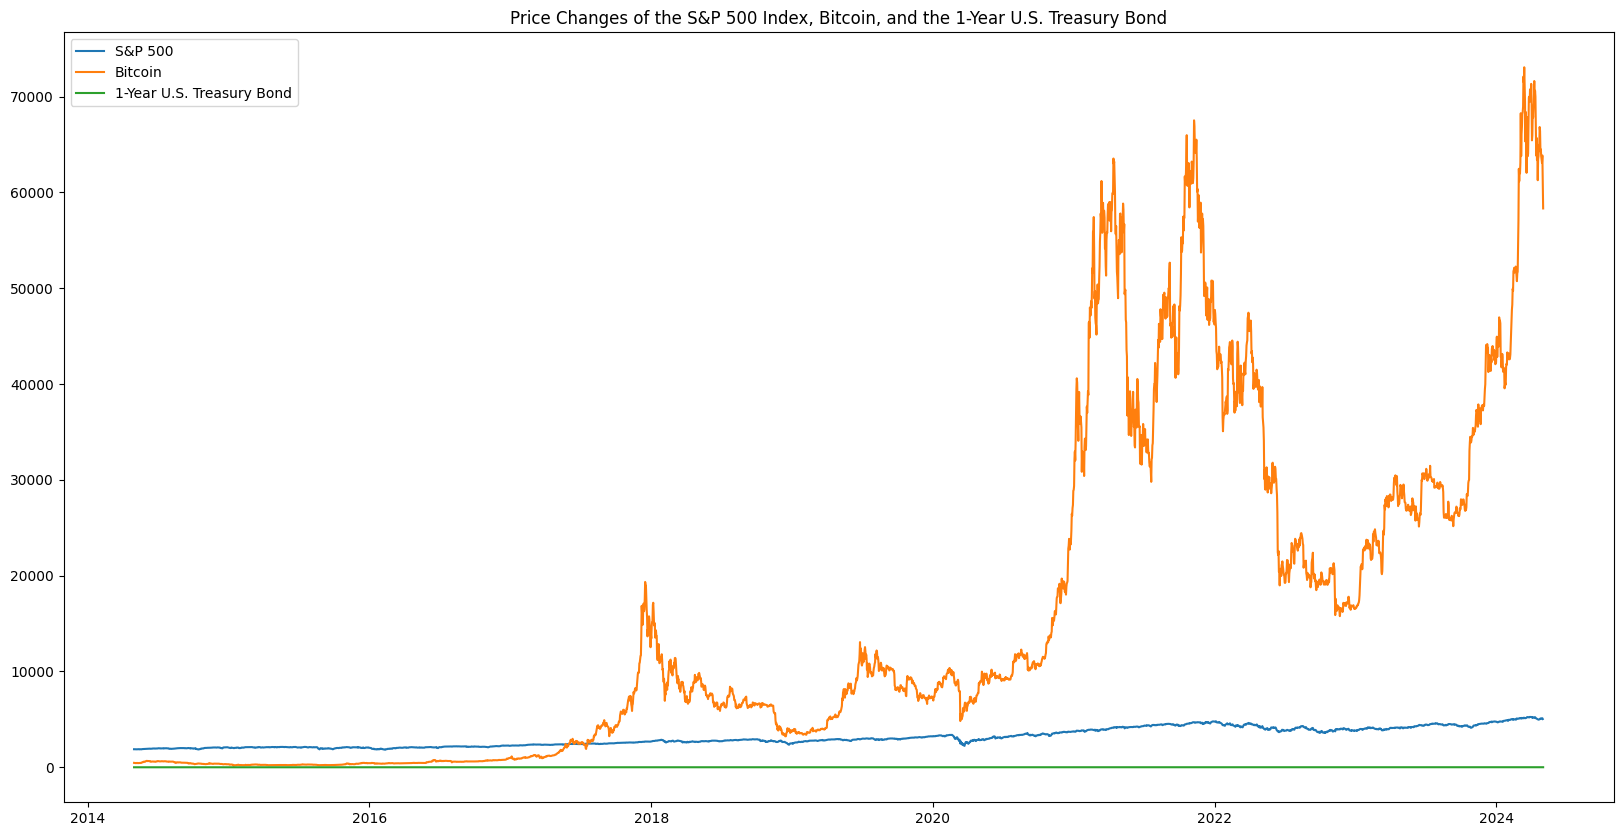

In [948]:
plt.figure(figsize=(20, 10))

plt.plot(df_SP500.index, df_SP500['Price'], label='S&P 500')
plt.plot(df_BTC.index, df_BTC['Price'], label='Bitcoin')
plt.plot(df_TMUBMUSD01Y.index, df_TMUBMUSD01Y['Price'], label='1-Year U.S. Treasury Bond')

plt.xlabel('')
plt.ylabel('')
plt.title('Price Changes of the S&P 500 Index, Bitcoin, and the 1-Year U.S. Treasury Bond')
plt.legend()
plt.show()

### S&P 500 Index

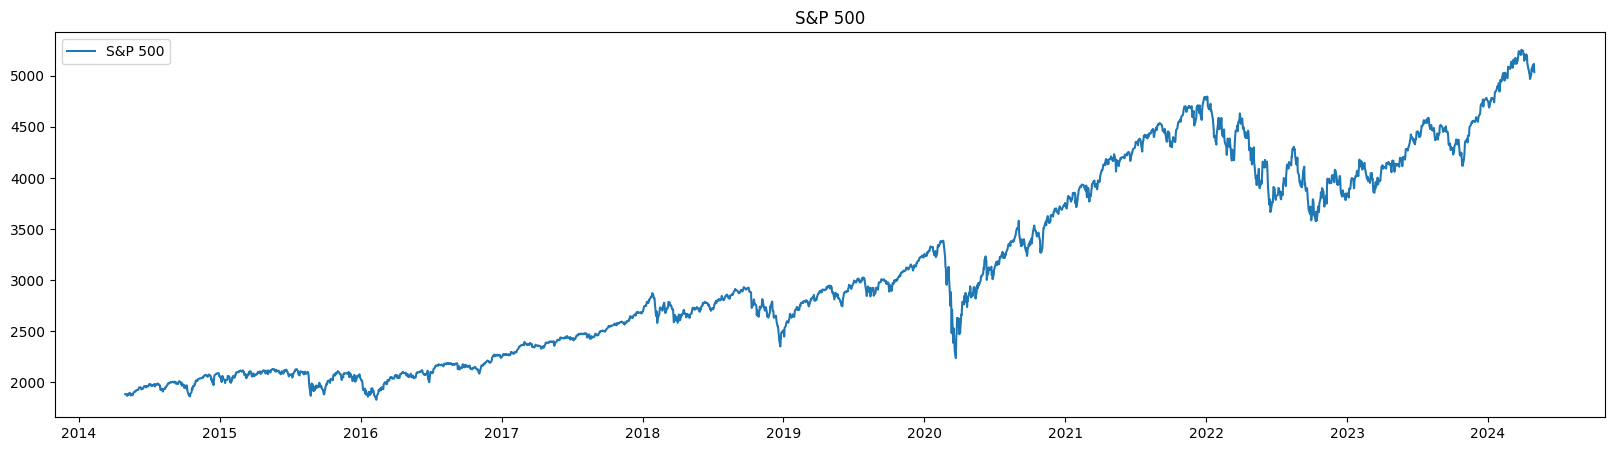

In [949]:
plt.figure(figsize=(20, 5))
plt.plot(df_SP500.index, df_SP500['Price'], label='S&P 500')
plt.xlabel('')
plt.ylabel('')
plt.title('S&P 500')
plt.legend()
plt.grid(False)
plt.show()

### Bitcoin

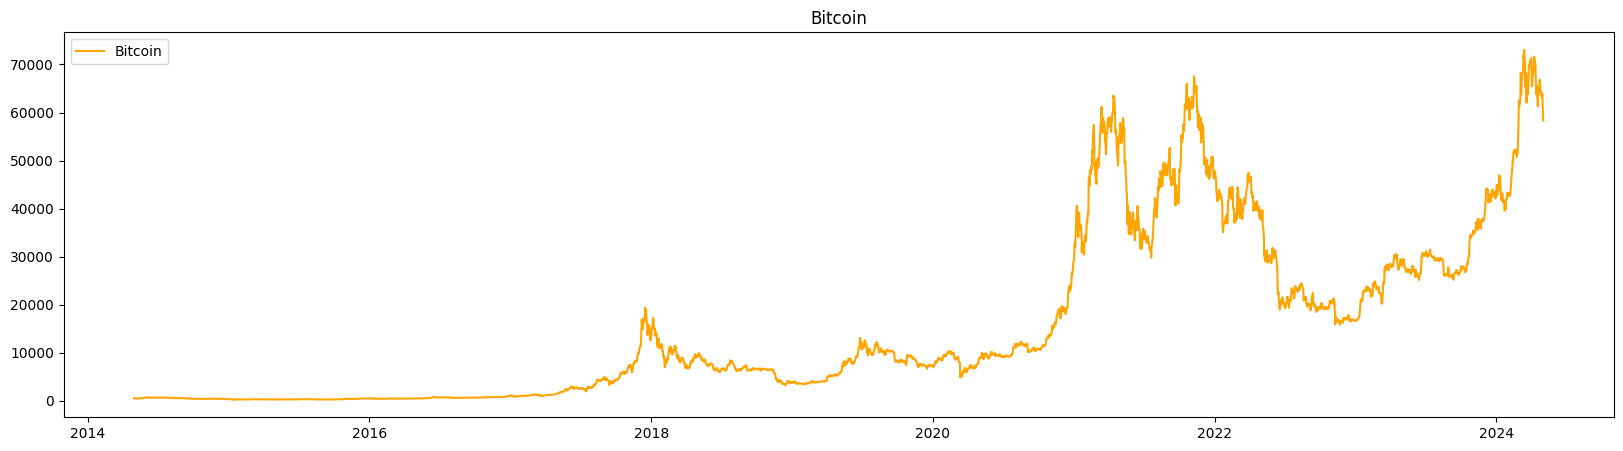

In [950]:
plt.figure(figsize=(20, 5))
plt.plot(df_BTC.index, df_BTC['Price'], label='Bitcoin', color='orange')
plt.xlabel('')
plt.ylabel('')
plt.title('Bitcoin')
plt.legend()
plt.grid(False)
plt.show()

### 1-Year U.S. Treasury Bond

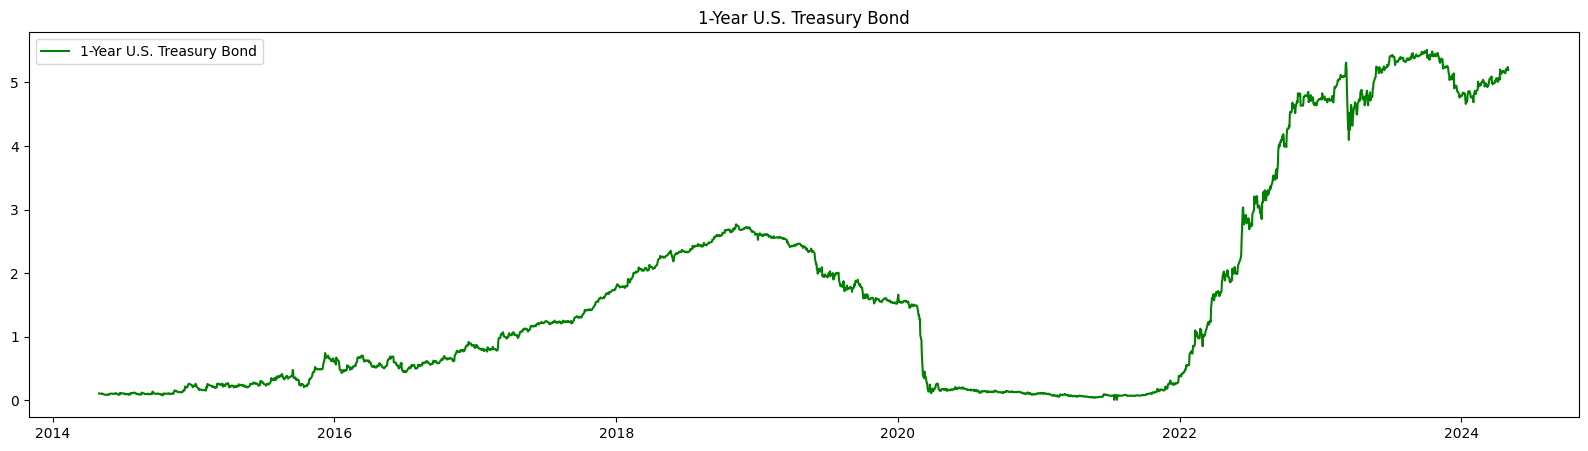

In [951]:
plt.figure(figsize=(20, 5))
plt.plot(df_TMUBMUSD01Y.index, df_TMUBMUSD01Y['Price'], label='1-Year U.S. Treasury Bond', color='green')
plt.xlabel('')
plt.ylabel('')
plt.title('1-Year U.S. Treasury Bond')
plt.legend()
plt.grid(False)
plt.show()

## Daily Returns

In [952]:
df_combined_returns = pd.concat([df_SP500[['Return']], df_BTC[['Return']], df_TMUBMUSD01Y[['Return']]], axis=1, join='inner')
df_combined_returns.columns = ['SP500_Return', 'BTC_Return', 'TMUBMUSD01Y_Return']

In [953]:
df_combined_returns

,SP500_Return,BTC_Return,TMUBMUSD01Y_Return
Date,,,
2014-05-01,NaN,NaN,NaN
2014-05-02,-0.001348,-0.013910,0.000000
2014-05-05,0.001871,-0.011697,-0.019231
2014-05-06,-0.008988,0.003017,0.000000
2014-05-07,0.005616,0.033087,-0.029412
...,...,...,...
2024-04-24,0.000213,-0.032061,0.001944
2024-04-25,-0.004576,0.003288,0.010475
2024-04-26,0.010209,-0.011329,-0.002496


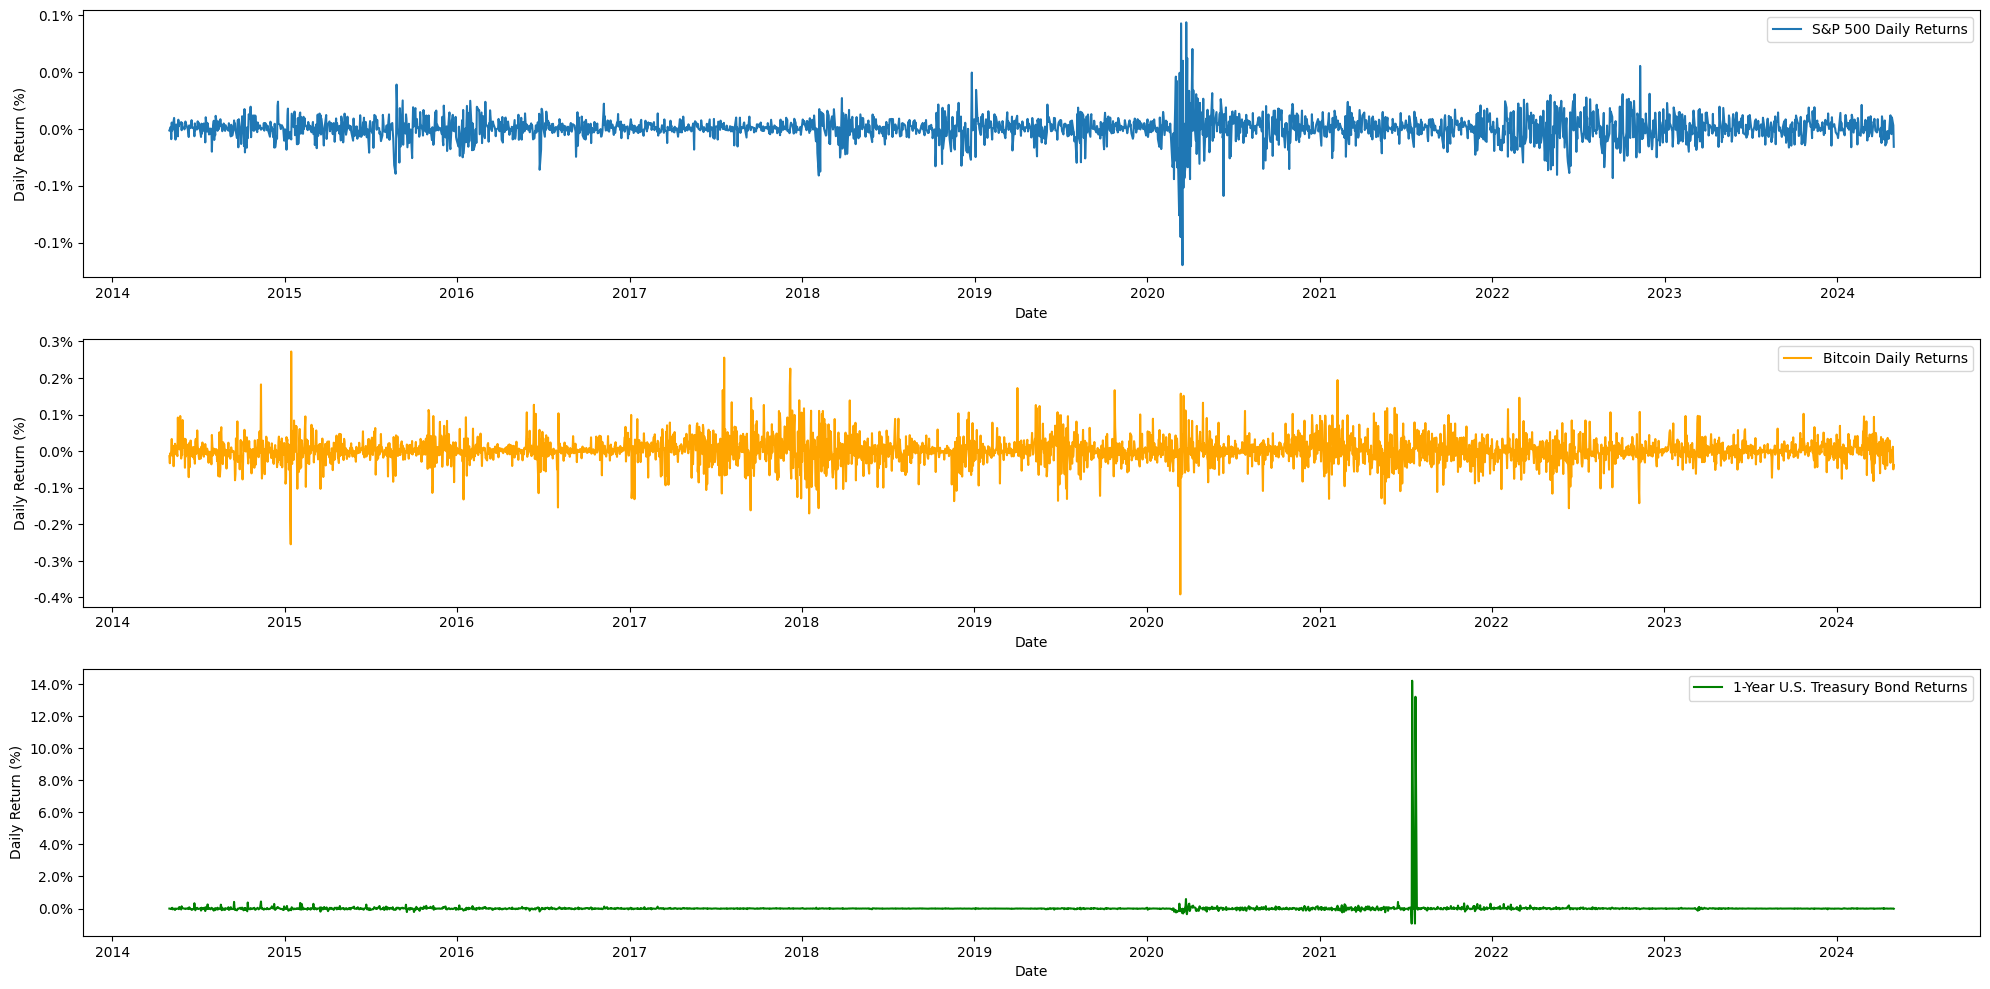

In [954]:
def percentage_formatter(x, pos):
    return f'{x:.1f}%'

plt.figure(figsize=(20, 10))

plt.subplot(3, 1, 1)
plt.plot(df_SP500.index, df_SP500['Return'], label='S&P 500 Daily Returns')
plt.title('')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df_BTC.index, df_BTC['Return'], label='Bitcoin Daily Returns', color='orange')
plt.title('')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(df_TMUBMUSD01Y.index, df_TMUBMUSD01Y['Return'], label='1-Year U.S. Treasury Bond Returns', color='green')
plt.title('')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
plt.legend()

plt.tight_layout()
plt.show()

## Forward-filling

In [955]:
""" Forward-filling missing values ensures consistency gaps 
by filling gaps with the last available observation, which is essential 
when aligning datasets with different trading schedules
, such as traditional markets and Bitcoin (Open on Weekends)."""

# This piece of code was taken from ChapGPT 
# Recommended using Forward-filling for Bitcoin

df_SP500 = df_SP500.asfreq('D').fillna(method='ffill')
df_TMUBMUSD01Y = df_TMUBMUSD01Y.asfreq('D').fillna(method='ffill')

# Linear Interpolation
df_SP500['Price'] = df_SP500['Price'].interpolate(method='linear')
df_TMUBMUSD01Y['Price'] = df_TMUBMUSD01Y['Price'].interpolate(method='linear')

## Merging Files

In [956]:
# Merge files & Rename Columns
df_assets = pd.merge(df_SP500, df_BTC, on='Date', how='outer')
df_assets = pd.merge(df_assets, df_TMUBMUSD01Y, on='Date', how='outer')

df_assets.columns = ['SP500_Price', 'SP500_Return', 'BTC_Price', 'BTC_Return', 'TMUBMUSD01Y_Price', 'TMUBMUSD01Y_Return']

# Drop NaN
df_assets.dropna(subset=['SP500_Return', 'BTC_Return', 'TMUBMUSD01Y_Return'], inplace=True)

# print(df_assets.head())

### + Macroeconomic Indicators

In [957]:
# Forward-filling
macro_data = pd.concat([UN_Rate, Real_GDP, CPI, VIX, Ten_Year_Treasury_Yield, Federal_Funds_Rate, BBB_Credit_Spread], axis=1).ffill()

# Merge with the assets
df_assets = df_assets.join(macro_data, how='left')

# Ffill and Bfill
df_assets = df_assets.ffill().bfill()

#print(df_assets.head())

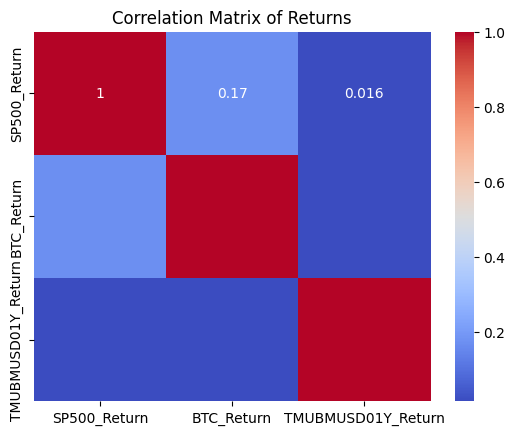

In [958]:
correlation_matrix = df_assets[['SP500_Return', 'BTC_Return', 'TMUBMUSD01Y_Return']].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Returns')
plt.show()

The correlation matrix shows that S&P 500 and Bitcoin returns have a weak positive correlation (0.17), while both have minimal correlation with 1-Year U.S. Treasury returns.

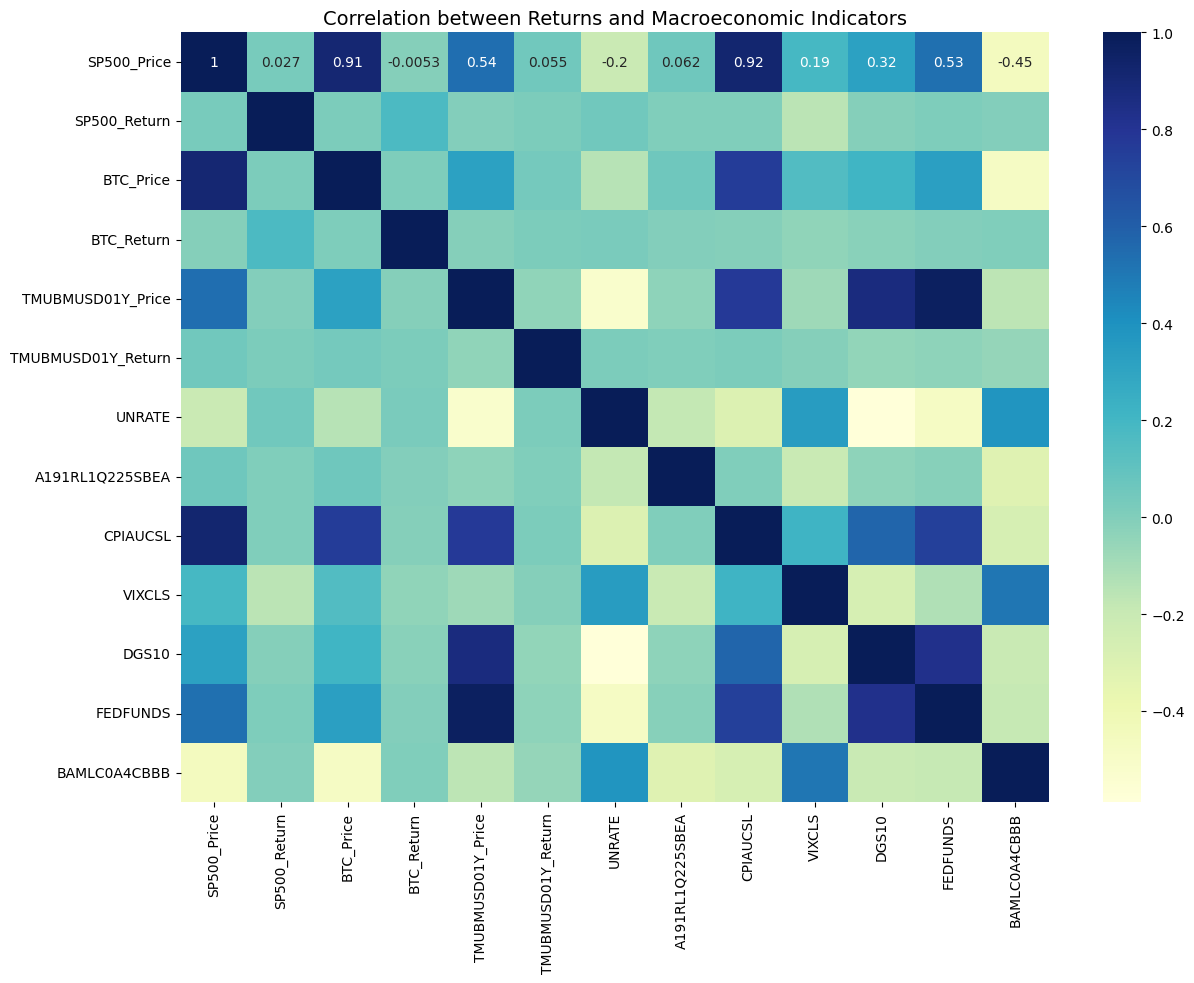

In [959]:
plt.figure(figsize=(14, 10))

correlation_matrix = df_assets.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', cbar=True)
plt.title('Correlation between Returns and Macroeconomic Indicators', fontsize=14)

plt.show()

#### Federal Funds Rate (0.32 with S&P 500, 0.32 with Bitcoin, 0.32 with 1-Year Treasury):
- Federal Funds Rates are positively correlated with returns for all three assets;

#### BBB Credit Spread (0.45 with S&P 500, 0.53 with Bitcoin, 0.22 with 1-Year Treasury):
- Moderate positive correlations with S&P 500 and Bitcoin returns indicate that larger credit spreads (risk premiums) are associated with higher returns for these riskier assets;

- Positive correlation with 1-Year Treasury returns shows that during times of increased credit risk, investors seek the safety of Treasuries;

#### Unemployment Rate (-0.2 with S&P 500, -0.2 with Bitcoin, -0.4 with 1-Year Treasury):
- Higher unemployment rates are negatively correlated with S&P 500 and Bitcoin returns;
- Negative correlation with 1-Year Treasury returns shows that higher unemployment rates drive investors to seek safer investments;

#### Real GDP (0.06 with S&P 500, -0.2 with Bitcoin, -0.22 with 1-Year Treasury):
- Higher GDP growth has a small positive impact on stock market returns;
- Negative correlation with Bitcoin and 1-Year Treasury returns implies that higher GDP growth leads to lower returns for these assets;

#### Consumer Price Index (0.19 with S&P 500, 0.19 with Bitcoin, -0.2 with 1-Year Treasury):
- Positive correlations with S&P 500 and Bitcoin returns indicate that higher inflation (CPI) corresponds to higher returns;
- Negative correlation with 1-Year Treasury returns shows that higher inflation reduces Treasury returns;

#### Volatility Index (VIX) (0.32 with S&P 500, 0.32 with Bitcoin, 0.32 with 1-Year Treasury):
- Positive correlations across all three assets indicate that higher market volatility is associated with higher returns;

#### 10-Year Treasury Yield (0.32 with S&P 500, 0.32 with Bitcoin, 0.32 with 1-Year Treasury):
- Moderate positive correlations with all three assets, meaning higher yields may coincide with higher returns, reflecting economic growth and higher interest rates.

## Statistical Analysis

### Summary

In [960]:
print(df_combined_returns.describe())

       SP500_Return   BTC_Return  TMUBMUSD01Y_Return
count   2500.000000  2500.000000         2500.000000
mean       0.000462     0.002399            0.013386
std        0.011183     0.039886            0.392496
min       -0.119841    -0.391816           -0.934211
25%       -0.003789    -0.013977           -0.011549
50%        0.000600     0.001383            0.000000
75%        0.005692     0.019091            0.013143
max        0.093828     0.272286           14.200000


In [961]:
print(df_combined_returns.skew())

SP500_Return          -0.518575
BTC_Return            -0.129652
TMUBMUSD01Y_Return    34.090014
dtype: float64


In [962]:
print(df_combined_returns.kurtosis())

SP500_Return            14.934157
BTC_Return               8.516432
TMUBMUSD01Y_Return    1192.704632
dtype: float64


S&P 500 and Bitcoin returns have small average returns, with Bitcoin is more volatile. S&P 500 returns are slightly left skewed, while Bitcoin is nearly symmetrical. Both have high kurtosis, meaning there are extreme values (outliers). 
The 1-Year Treasury Bond returns show extreme positive skew and high kurtosis due to a few very large returns. These results indicate non-normal distributions.

### ADF

In [963]:
def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Reject the null hypothesis - stationary")
    else:
        print("Fail to reject the null hypothesis - non-stationary")

adf_test(df_combined_returns['SP500_Return'])
adf_test(df_combined_returns['BTC_Return'])
adf_test(df_combined_returns['TMUBMUSD01Y_Return'])

ADF Statistic: -15.696102760271707
p-value: 1.4145081703855867e-28
Reject the null hypothesis - stationary
ADF Statistic: -27.879839702337545
p-value: 0.0
Reject the null hypothesis - stationary
ADF Statistic: -8.657891314817109
p-value: 4.9121247555259015e-14
Reject the null hypothesis - stationary


We reject the null hypothesis, concluding that the data is stationary.

### KDE

The KDE plots show that the distributions of S&P 500 and Bitcoin returns are centered around zero with heavy tails, suggesting high volatility. In contrast, the 1-Year U.S. Treasury Bond returns display positive skew with extreme values.

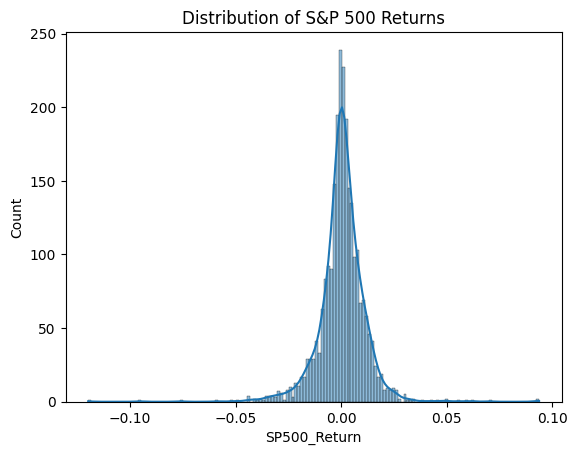

In [964]:
sns.histplot(df_combined_returns['SP500_Return'], kde=True)
plt.title('Distribution of S&P 500 Returns')
plt.show()

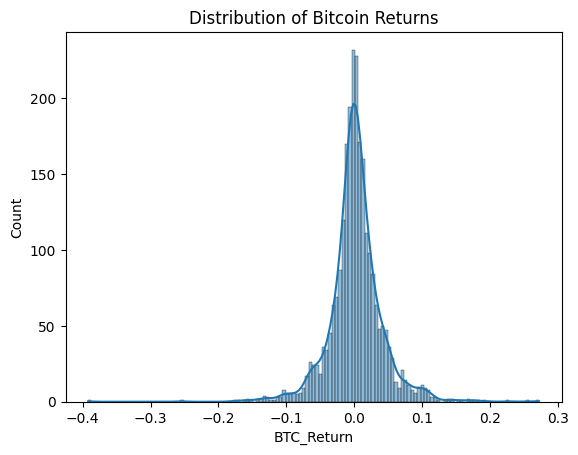

In [965]:
sns.histplot(df_combined_returns['BTC_Return'], kde=True)
plt.title('Distribution of Bitcoin Returns')
plt.show()

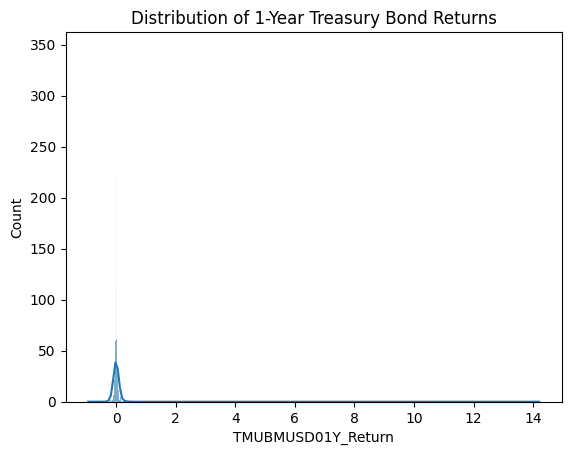

In [966]:
sns.histplot(df_combined_returns['TMUBMUSD01Y_Return'], kde=True)
plt.title('Distribution of 1-Year Treasury Bond Returns')
plt.show()

### Shapiro-Wilk Test

In [967]:
def shapiro_test(series):
    stat, p_value = shapiro(series.dropna())
    print(f'Shapiro-Wilk Test: Statistics={stat}, p-value={p_value}')
    if p_value > 0.05:
        print("Fail to reject the null hypothesis - data is normally distributed")
    else:
        print("Reject the null hypothesis - data is not normally distributed")

In [968]:
print("SP500 Returns:")
shapiro_test(df_combined_returns['SP500_Return'])

print("\nBTC Returns:")
shapiro_test(df_combined_returns['BTC_Return'])

print("\n1-Year Treasury Bond Returns:")
shapiro_test(df_combined_returns['TMUBMUSD01Y_Return'])

SP500 Returns:
Shapiro-Wilk Test: Statistics=0.8778822422027588, p-value=1.5476921148928307e-40
Reject the null hypothesis - data is not normally distributed

BTC Returns:
Shapiro-Wilk Test: Statistics=0.9119336605072021, p-value=7.92419654261794e-36
Reject the null hypothesis - data is not normally distributed

1-Year Treasury Bond Returns:
Shapiro-Wilk Test: Statistics=0.05089300870895386, p-value=0.0
Reject the null hypothesis - data is not normally distributed


### Plots

The box plots reveal that both the S&P 500 and Bitcoin returns have numerous outliers, indicating extreme values, while the 1-Year U.S. Treasury Bond returns exhibit significant positive outliers. 

These findings suggest the need to investigate whether these extreme values are associated with specific market events.

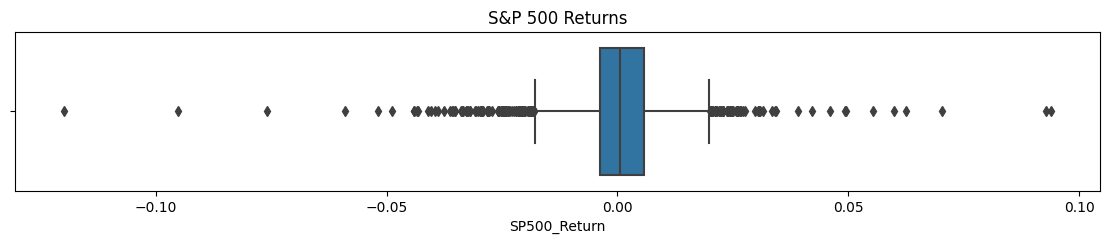

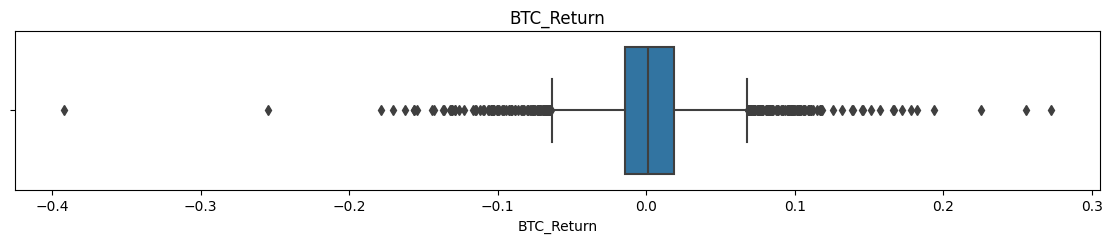

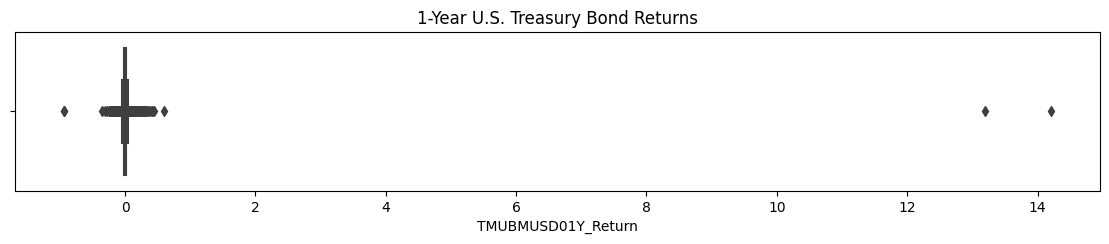

In [969]:
plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 1)
sns.boxplot(x=df_combined_returns['SP500_Return'])
plt.title('S&P 500 Returns')

plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 2)
sns.boxplot(x=df_combined_returns['BTC_Return'])
plt.title('BTC_Return')

plt.figure(figsize=(14, 7))

plt.subplot(3, 1, 3)
sns.boxplot(x=df_combined_returns['TMUBMUSD01Y_Return'])
plt.title('1-Year U.S. Treasury Bond Returns')

plt.show()

### Outliers

In [970]:
def extreme_values(df, column, percentile=0.01):
    threshold_high = df[column].quantile(1 - percentile)
    threshold_low = df[column].quantile(percentile)
    high = df[df[column] >= threshold_high]
    low = df[df[column] <= threshold_low]
    return high, low

In [971]:
high_sp500, low_sp500 = extreme_values(df_combined_returns, 'SP500_Return')
high_btc, low_btc = extreme_values(df_combined_returns, 'BTC_Return')
high_treasury, low_treasury = extreme_values(df_combined_returns, 'TMUBMUSD01Y_Return')

In [972]:
extreme_sp500_dates = high_sp500.index.union(low_sp500.index)
print(extreme_sp500_dates)

DatetimeIndex(['2015-08-24', '2015-08-26', '2016-06-24', '2018-02-05',
               '2018-02-08', '2018-03-26', '2018-10-10', '2018-12-26',
               '2019-01-04', '2020-02-24', '2020-02-27', '2020-03-02',
               '2020-03-04', '2020-03-05', '2020-03-09', '2020-03-10',
               '2020-03-11', '2020-03-12', '2020-03-13', '2020-03-16',
               '2020-03-17', '2020-03-18', '2020-03-20', '2020-03-24',
               '2020-03-26', '2020-03-27', '2020-03-30', '2020-04-01',
               '2020-04-06', '2020-04-08', '2020-04-14', '2020-04-17',
               '2020-04-29', '2020-05-18', '2020-06-11', '2020-09-03',
               '2020-10-28', '2022-04-29', '2022-05-04', '2022-05-05',
               '2022-05-18', '2022-06-13', '2022-06-24', '2022-07-19',
               '2022-08-26', '2022-09-13', '2022-10-04', '2022-10-17',
               '2022-11-10', '2022-11-30'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [973]:
extreme_btc_dates = high_btc.index.union(low_btc.index)
print(extreme_btc_dates)

DatetimeIndex(['2014-11-12', '2015-01-13', '2015-01-14', '2015-01-15',
               '2015-11-02', '2015-11-10', '2016-01-15', '2016-06-22',
               '2016-08-02', '2017-01-05', '2017-01-11', '2017-07-17',
               '2017-07-20', '2017-09-14', '2017-09-15', '2017-09-18',
               '2017-10-12', '2017-12-06', '2017-12-07', '2017-12-22',
               '2017-12-26', '2018-01-05', '2018-01-16', '2018-02-05',
               '2018-04-12', '2018-11-19', '2019-04-02', '2019-05-13',
               '2019-06-27', '2019-07-16', '2019-09-24', '2019-10-25',
               '2020-03-12', '2020-03-13', '2020-03-19', '2020-03-23',
               '2020-04-29', '2021-01-21', '2021-02-08', '2021-05-12',
               '2021-05-19', '2021-05-24', '2021-06-09', '2021-06-21',
               '2021-09-07', '2022-02-04', '2022-02-28', '2022-05-09',
               '2022-06-13', '2022-11-09'],
              dtype='datetime64[ns]', name='Date', freq=None)


In [974]:
extreme_treasury_dates = high_treasury.index.union(low_treasury.index)
print(extreme_treasury_dates)

DatetimeIndex(['2014-06-24', '2014-07-22', '2014-08-19', '2014-09-16',
               '2014-10-14', '2014-10-15', '2014-11-12', '2014-12-10',
               '2015-02-03', '2015-02-06', '2015-03-03', '2015-03-18',
               '2015-06-23', '2015-09-15', '2015-09-17', '2015-10-02',
               '2016-06-24', '2020-02-28', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-10', '2020-03-16',
               '2020-03-18', '2020-03-20', '2020-03-24', '2020-03-25',
               '2020-03-26', '2020-03-30', '2020-03-31', '2020-05-07',
               '2021-02-18', '2021-02-22', '2021-02-23', '2021-03-19',
               '2021-03-29', '2021-05-20', '2021-06-16', '2021-07-15',
               '2021-07-16', '2021-07-22', '2021-07-23', '2021-11-03',
               '2021-11-05', '2021-11-26', '2021-12-01', '2021-12-29',
               '2022-01-26', '2022-02-10'],
              dtype='datetime64[ns]', name='Date', freq=None)


### Conclusion

COVID-19 pandemic was the major driver of extreme market movements across these different asset classes.

## ACF & PACF

<Figure size 1200x600 with 0 Axes>

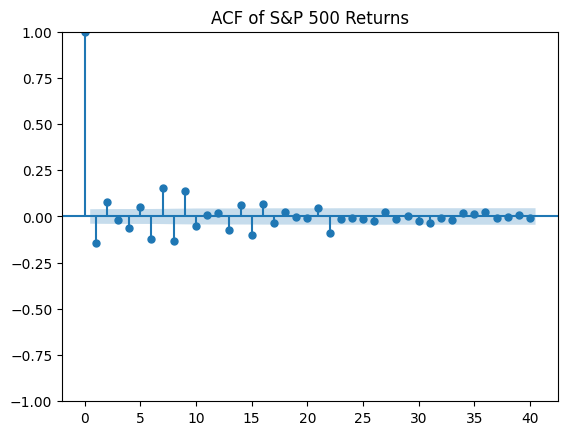

<Figure size 1200x600 with 0 Axes>

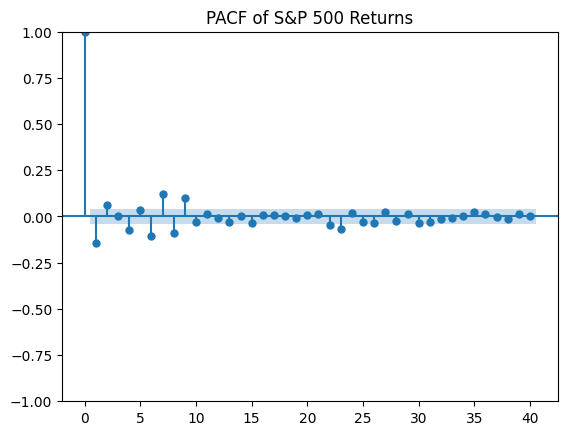

In [975]:
plt.figure(figsize=(12, 6))
plot_acf(df_combined_returns['SP500_Return'].dropna(), lags=40)
plt.title('ACF of S&P 500 Returns')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df_combined_returns['SP500_Return'].dropna(), lags=40)
plt.title('PACF of S&P 500 Returns')
plt.show()

<Figure size 1200x600 with 0 Axes>

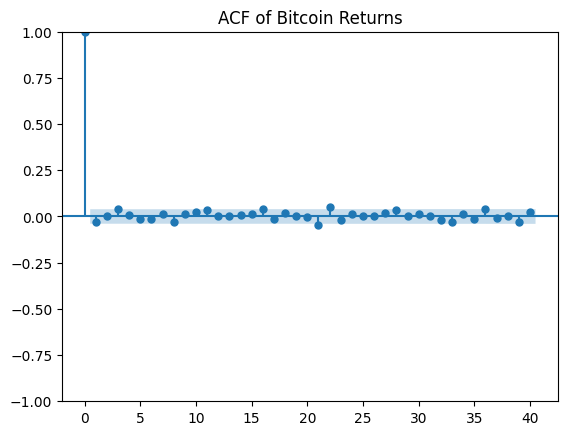

<Figure size 1200x600 with 0 Axes>

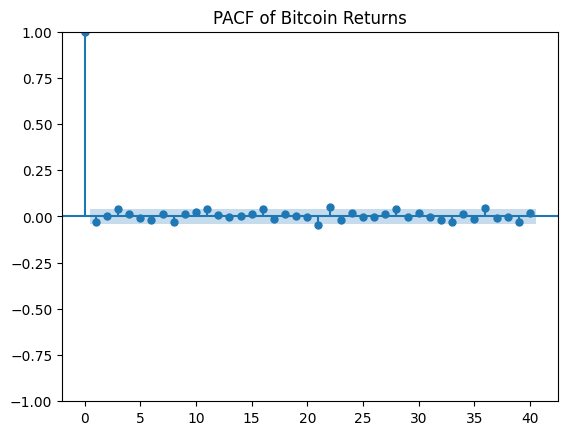

In [976]:
plt.figure(figsize=(12, 6))
plot_acf(df_combined_returns['BTC_Return'].dropna(), lags=40)
plt.title('ACF of Bitcoin Returns')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df_combined_returns['BTC_Return'].dropna(), lags=40)
plt.title('PACF of Bitcoin Returns')
plt.show()

<Figure size 1200x600 with 0 Axes>

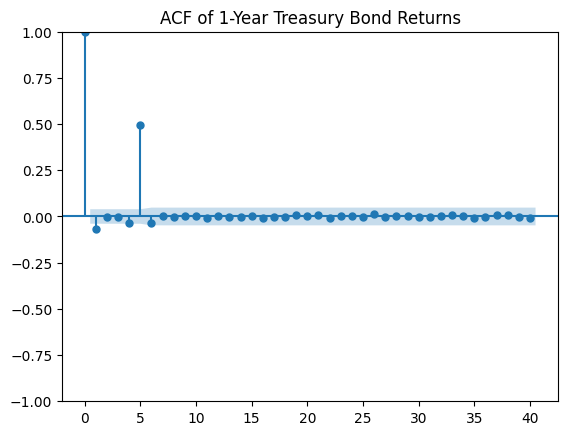

<Figure size 1200x600 with 0 Axes>

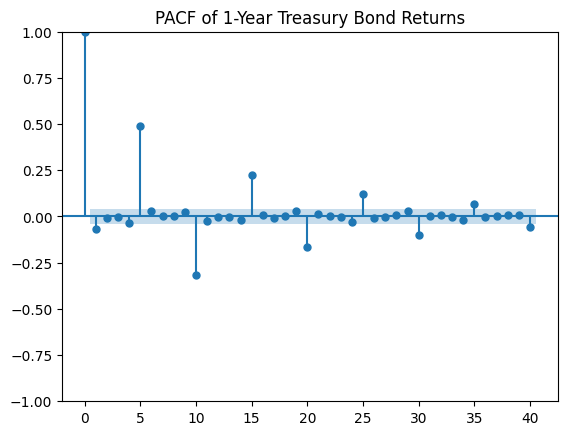

In [977]:
plt.figure(figsize=(12, 6))
plot_acf(df_combined_returns['TMUBMUSD01Y_Return'].dropna(), lags=40)
plt.title('ACF of 1-Year Treasury Bond Returns')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df_combined_returns['TMUBMUSD01Y_Return'].dropna(), lags=40)
plt.title('PACF of 1-Year Treasury Bond Returns')
plt.show()

- S&P 500: The average returns are stable, but volatility spiked during the COVID-19 pandemic in early 2020, indicating increased market uncertainty.

- Bitcoin: Returns are more volatile than the S&P 500, with several large spikes, showing higher risk and instability, especially during economic events.

- 1-Year Treasury Bond: Typically very stable with low volatility, except for a sharp increase during the COVID-19 pandemic, reflecting its role as a safe-haven asset.

# Feature Engineering

## Outliers in returns can skew your analysis. Consider winsorizing the returns to mitigate their impact.

In [978]:
def winsorize_series(series, limits):
    return winsorize(series, limits=limits)

df_assets['SP500_Return'] = winsorize_series(df_assets['SP500_Return'], limits=[0.01, 0.01])
df_assets['BTC_Return'] = winsorize_series(df_assets['BTC_Return'], limits=[0.01, 0.01])
df_assets['TMUBMUSD01Y_Return'] = winsorize_series(df_assets['TMUBMUSD01Y_Return'], limits=[0.01, 0.01])

## Calculating Log Returns

In [979]:
df_assets['SP500_Log_Return'] = np.log(df_assets['SP500_Price'] / df_assets['SP500_Price'].shift(1))
df_assets['BTC_Log_Return'] = np.log(df_assets['BTC_Price'] / df_assets['BTC_Price'].shift(1))
df_assets['TMUBMUSD01Y_Log_Return'] = np.log(df_assets['TMUBMUSD01Y_Price'] / df_assets['TMUBMUSD01Y_Price'].shift(1))

Log Returns: Calculated for each asset to normalize the data and measure the continuous rate of return.

In [980]:
scaler = StandardScaler()

df_assets[['SP500_Log_Return', 'BTC_Log_Return', 'TMUBMUSD01Y_Log_Return']] = scaler.fit_transform(df_assets[['SP500_Log_Return', 'BTC_Log_Return', 'TMUBMUSD01Y_Log_Return']])

## Calculating Lagged Returns

In [981]:
df_assets['SP500_Lagged_Return'] = df_assets['SP500_Return'].shift(1)
df_assets['BTC_Lagged_Return'] = df_assets['BTC_Return'].shift(1)
df_assets['TMUBMUSD01Y_Lagged_Return'] = df_assets['TMUBMUSD01Y_Return'].shift(1)

Lagged Log Returns: Calculated to capture temporal dependencies and previous returns impact.

## Rolling Statistics

#### Calculate and plot rolling std for all portfolios with 21-day window

In [982]:
# Reference: Portfolio_Performance repository
# File: whale_analysis.ipynb
# URL: https://github.com/lrb924/Portfolio_Performance/blob/main/whale_analysis.ipynb

window = 21

df_assets['SP500_Rolling_Mean'] = df_assets['SP500_Log_Return'].rolling(window).mean()
df_assets['SP500_Rolling_Std'] = df_assets['SP500_Log_Return'].rolling(window).std()

df_assets['BTC_Rolling_Mean'] = df_assets['BTC_Log_Return'].rolling(window).mean()
df_assets['BTC_Rolling_Std'] = df_assets['BTC_Log_Return'].rolling(window).std()

df_assets['TMUBMUSD01Y_Rolling_Mean'] = df_assets['TMUBMUSD01Y_Log_Return'].rolling(window).mean()
df_assets['TMUBMUSD01Y_Rolling_Std'] = df_assets['TMUBMUSD01Y_Log_Return'].rolling(window).std()

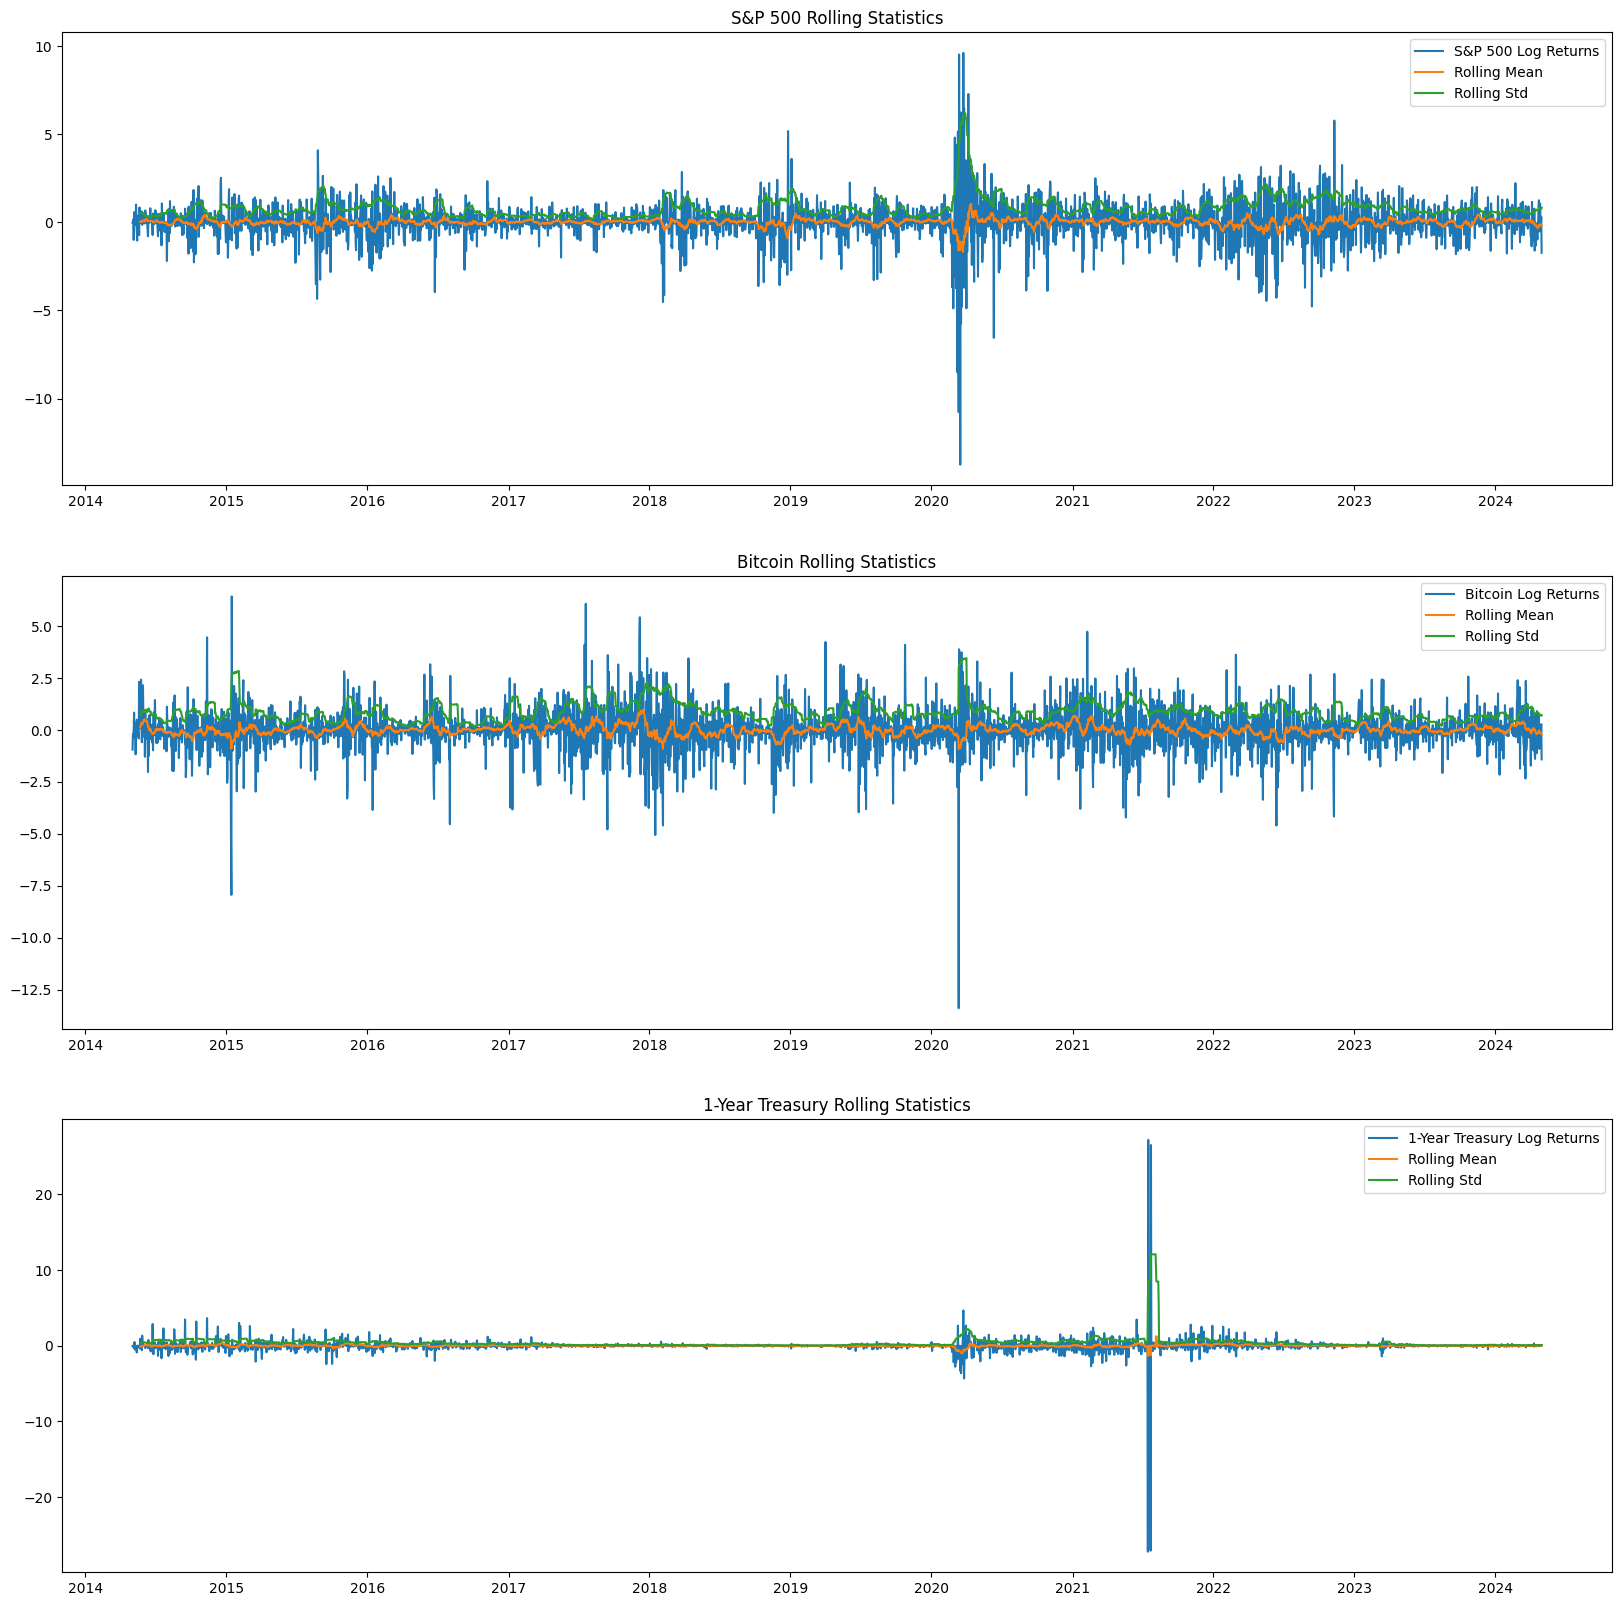

In [983]:
plt.figure(figsize=(20, 20))

plt.subplot(3, 1, 1)
plt.plot(df_assets.index, df_assets['SP500_Log_Return'], label='S&P 500 Log Returns')
plt.plot(df_assets.index, df_assets['SP500_Rolling_Mean'], label='Rolling Mean')
plt.plot(df_assets.index, df_assets['SP500_Rolling_Std'], label='Rolling Std')
plt.title('S&P 500 Rolling Statistics')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(df_assets.index, df_assets['BTC_Log_Return'], label='Bitcoin Log Returns')
plt.plot(df_assets.index, df_assets['BTC_Rolling_Mean'], label='Rolling Mean')
plt.plot(df_assets.index, df_assets['BTC_Rolling_Std'], label='Rolling Std')
plt.title('Bitcoin Rolling Statistics')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(df_assets.index, df_assets['TMUBMUSD01Y_Log_Return'], label='1-Year Treasury Log Returns')
plt.plot(df_assets.index, df_assets['TMUBMUSD01Y_Rolling_Mean'], label='Rolling Mean')
plt.plot(df_assets.index, df_assets['TMUBMUSD01Y_Rolling_Std'], label='Rolling Std')
plt.title('1-Year Treasury Rolling Statistics')
plt.legend()

plt.show()

Rolling Statistics: track changes over time.

## Exponential Moving averages

In [984]:
df_assets['SP500_EMA'] = df_assets['SP500_Log_Return'].ewm(span=21, adjust=False).mean()
df_assets['BTC_EMA'] = df_assets['BTC_Log_Return'].ewm(span=21, adjust=False).mean()
df_assets['TMUBMUSD01Y_EMA'] = df_assets['TMUBMUSD01Y_Log_Return'].ewm(span=21, adjust=False).mean()

Exponential Moving Averages: to smooth out short-term fluctuations and highlight trends.

## Interaction Features

Let's make a compreensive use of the macroeconomic indicators and add interactions between them and between them and macroeconomic indicators.

In [985]:
# Interaction between Log Returns
df_assets['SP500_BTC_Interaction'] = df_assets['SP500_Log_Return'] * df_assets['BTC_Log_Return']
df_assets['SP500_Treasury_Interaction'] = df_assets['SP500_Log_Return'] * df_assets['TMUBMUSD01Y_Log_Return']
df_assets['BTC_Treasury_Interaction'] = df_assets['BTC_Log_Return'] * df_assets['TMUBMUSD01Y_Log_Return']

# Interaction between SP500 Log Returns and macroeconomic indicators
df_assets['SP500_UNRATE_Interaction'] = df_assets['SP500_Log_Return'] * df_assets['UNRATE']
df_assets['SP500_GDP_Interaction'] = df_assets['SP500_Log_Return'] * df_assets['A191RL1Q225SBEA']
df_assets['SP500_CPI_Interaction'] = df_assets['SP500_Log_Return'] * df_assets['CPIAUCSL']
df_assets['SP500_VIX_Interaction'] = df_assets['SP500_Log_Return'] * df_assets['VIXCLS']
df_assets['SP500_Treasury_Yield_Interaction'] = df_assets['SP500_Log_Return'] * df_assets['DGS10']
df_assets['SP500_Fed_Funds_Interaction'] = df_assets['SP500_Log_Return'] * df_assets['FEDFUNDS']
df_assets['SP500_Credit_Spread_Interaction'] = df_assets['SP500_Log_Return'] * df_assets['BAMLC0A4CBBB']

# Interaction between Bitcoin Log Returns and macroeconomic indicators
df_assets['BTC_UNRATE_Interaction'] = df_assets['BTC_Log_Return'] * df_assets['UNRATE']
df_assets['BTC_GDP_Interaction'] = df_assets['BTC_Log_Return'] * df_assets['A191RL1Q225SBEA']
df_assets['BTC_CPI_Interaction'] = df_assets['BTC_Log_Return'] * df_assets['CPIAUCSL']
df_assets['BTC_VIX_Interaction'] = df_assets['BTC_Log_Return'] * df_assets['VIXCLS']
df_assets['BTC_Treasury_Yield_Interaction'] = df_assets['BTC_Log_Return'] * df_assets['DGS10']
df_assets['BTC_Fed_Funds_Interaction'] = df_assets['BTC_Log_Return'] * df_assets['FEDFUNDS']
df_assets['BTC_Credit_Spread_Interaction'] = df_assets['BTC_Log_Return'] * df_assets['BAMLC0A4CBBB']

# Interaction between 1-Year Treasury Log Returns and macroeconomic indicators
df_assets['Treasury_UNRATE_Interaction'] = df_assets['TMUBMUSD01Y_Log_Return'] * df_assets['UNRATE']
df_assets['Treasury_GDP_Interaction'] = df_assets['TMUBMUSD01Y_Log_Return'] * df_assets['A191RL1Q225SBEA']
df_assets['Treasury_CPI_Interaction'] = df_assets['TMUBMUSD01Y_Log_Return'] * df_assets['CPIAUCSL']
df_assets['Treasury_VIX_Interaction_Log'] = df_assets['TMUBMUSD01Y_Log_Return'] * df_assets['VIXCLS']
df_assets['Treasury_Treasury_Yield_Interaction'] = df_assets['TMUBMUSD01Y_Log_Return'] * df_assets['DGS10']
df_assets['Treasury_Fed_Funds_Interaction'] = df_assets['TMUBMUSD01Y_Log_Return'] * df_assets['FEDFUNDS']
df_assets['Treasury_Credit_Spread_Interaction'] = df_assets['TMUBMUSD01Y_Log_Return'] * df_assets['BAMLC0A4CBBB']

Interaction Terms: Created between log returns and macroeconomic indicators to capture combined effects.

## Let's check how the data looks at this point:

In [986]:
df_assets

,SP500_Price,SP500_Return,BTC_Price,BTC_Return,TMUBMUSD01Y_Price,TMUBMUSD01Y_Return,UNRATE,A191RL1Q225SBEA,CPIAUCSL,VIXCLS,...,BTC_Treasury_Yield_Interaction,BTC_Fed_Funds_Interaction,BTC_Credit_Spread_Interaction,Treasury_UNRATE_Interaction,Treasury_GDP_Interaction,Treasury_CPI_Interaction,Treasury_VIX_Interaction_Log,Treasury_Treasury_Yield_Interaction,Treasury_Fed_Funds_Interaction,Treasury_Credit_Spread_Interaction
Date,,,,,,,,,,,,,,,,,,,,,
2014-05-02,1881.140015,-0.001348,453.7,-0.013910,0.104,0.000000,6.3,5.0,236.918,12.91,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-05-03,1881.140015,-0.001348,438.6,-0.033282,0.104,0.000000,6.3,5.0,236.918,12.91,...,-2.457551,-0.085069,-1.455626,-0.067555,-0.053615,-2.540480,-0.138434,-0.027880,-0.000965,-0.016513
2014-05-04,1881.140015,-0.001348,436.0,-0.005928,0.104,0.000000,6.3,5.0,236.918,12.91,...,-0.508876,-0.017615,-0.301411,-0.067555,-0.053615,-2.540480,-0.138434,-0.027880,-0.000965,-0.016513
2014-05-05,1884.660034,0.001871,430.9,-0.011697,0.102,-0.019231,6.3,5.0,236.918,13.29,...,-0.925938,-0.031686,-0.542184,-1.289188,-1.023165,-48.481247,-2.719573,-0.538185,-0.018417,-0.315135
2014-05-06,1867.719971,-0.008988,432.2,0.003017,0.102,0.000000,6.3,5.0,236.918,13.80,...,0.117182,0.004041,0.068693,-0.067555,-0.053615,-2.540480,-0.147978,-0.027987,-0.000965,-0.016406
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,5099.959961,0.010209,63766.4,-0.011329,5.196,-0.002496,3.9,1.3,313.207,15.03,...,-1.597450,-1.823213,-0.386535,-0.139137,-0.046379,-11.174029,-0.536213,-0.166608,-0.190154,-0.040314
2024-04-27,5099.959961,0.010209,63456.8,-0.004855,5.196,-0.002496,3.9,1.3,313.207,15.03,...,-0.778727,-0.888783,-0.188429,-0.041820,-0.013940,-3.358530,-0.161167,-0.050077,-0.057154,-0.012117
2024-04-28,5099.959961,0.010209,63109.7,-0.005470,5.196,-0.002496,3.9,1.3,313.207,15.03,...,-0.856228,-0.977237,-0.207181,-0.041820,-0.013940,-3.358530,-0.161167,-0.050077,-0.057154,-0.012117


Looks good !! We are ready to move to volatility modelling using Garch !!!

# Modeling

## GARCH Model

We will use the GARCH model to understand how volatility changes over time for our assets (Bitcoin, S&P 500, and 1-Year Treasury Bonds).

- HVaR: GARCH refines our historical risk estimates by accounting for volatility clusters.

- Parametric VaR: GARCH enhances parametric risk models by accurately estimating volatility and tail risks.

- MC VaR: GARCH improves our simulations by providing realistic volatility patterns.

- CVaR: By understanding volatility, GARCH gives us a clearer picture of potential extreme losses.

In summary, it makes our risk estimates more accurate and reliable by capturing the real-world behavior of asset volatility.

In [1017]:
# Basic Code for reference:

# Reference: volatility-modeling-python-datasci repository
# File: Thesis_code-statsmodels_dev.ipynb
# URL: https://github.com/MajorLift/volatility-modeling-python-datasci.git

# -> Idea -> using Garch + More advanced models:

# Reference: volatility-garch-VaR repository
# File: garch_estimate.R
# URL: https://github.com/anhdanggit/volatility-garch-VaR/blob/master/code/garch_estimate.R

def fit_garch(series, title):
    series = series.dropna()
    garch_model = arch_model(series, vol='Garch', p=1, q=1)
    garch_fit = garch_model.fit(disp='off')
    print(f'\n{title} GARCH(1,1) Summary')
    

    plt.figure(figsize=(10, 4))
    plt.plot(garch_fit.conditional_volatility)
    plt.title(f'Conditional Volatility from GARCH(1,1) Model for {title}')
    plt.show()
    
    return garch_fit

#### S&P 500 Returns:
The GARCH(1,1) model for S&P 500 returns shows that volatility has spikes, especially during market turbulence, and then gradually decreases. The high beta value (0.88) indicates strong persistence in volatility. This means that once volatility increases, it tends to remain high for a while.


S&P 500 GARCH(1,1) Summary


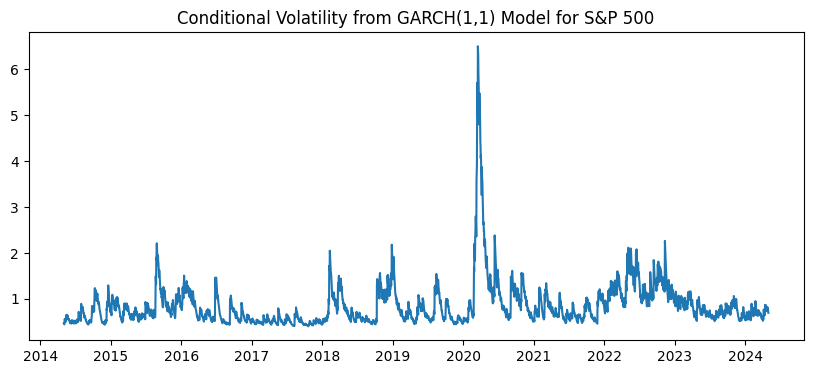

                     Constant Mean - GARCH Model Results                      
Dep. Variable:       SP500_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4260.82
Distribution:                  Normal   AIC:                           8529.65
Method:            Maximum Likelihood   BIC:                           8554.46
                                        No. Observations:                 3651
Date:                Sat, Jun 08 2024   Df Residuals:                     3650
Time:                        17:44:19   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0291  1.163e-02      2.506  1.219e-02 [6.

In [1018]:
fit_garch(df_assets['SP500_Log_Return'], 'S&P 500')

#### Bitcoin Returns:
For Bitcoin returns, the GARCH(1,1) model reveals significant volatility with numerous spikes, indicating Bitcoin’s high-risk nature. The alpha (0.14) and beta (0.83) values suggest that while shocks to volatility are less persistent than for the S&P 500, the volatility still shows strong clustering.


Bitcoin GARCH(1,1) Summary


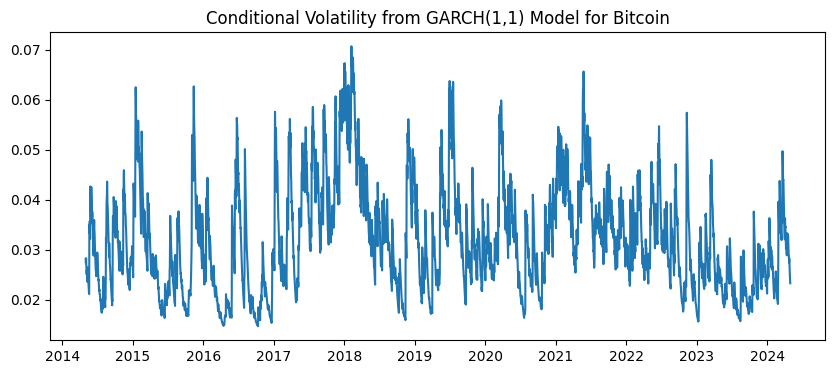

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             BTC_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                7428.33
Distribution:                  Normal   AIC:                          -14848.7
Method:            Maximum Likelihood   BIC:                          -14823.9
                                        No. Observations:                 3652
Date:                Sat, Jun 08 2024   Df Residuals:                     3651
Time:                        17:44:20   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.6968e-03  4.962e-04      3.419  6.277e-04 [7.

In [1019]:
fit_garch(df_assets['BTC_Return'], 'Bitcoin')

#### 1-Year Treasury Bond Returns:
The 1-Year Treasury Bond returns' GARCH(1,1) model shows low volatility most of the time, with a significant spike during the COVID-19 pandemic. The alpha value (0.10) indicates sensitivity to new information, and the beta value (0.88) suggests that volatility, while usually low, can remain elevated for a period after a spike.


1-Year Treasury Bond GARCH(1,1) Summary


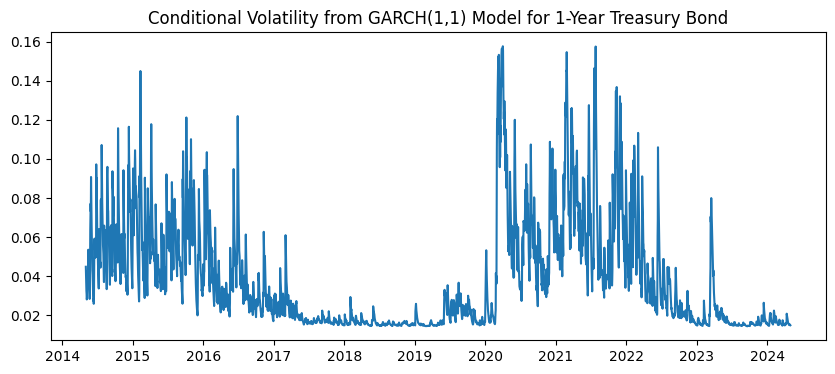

                     Constant Mean - GARCH Model Results                      
Dep. Variable:     TMUBMUSD01Y_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                7625.77
Distribution:                  Normal   AIC:                          -15243.5
Method:            Maximum Likelihood   BIC:                          -15218.7
                                        No. Observations:                 3652
Date:                Sat, Jun 08 2024   Df Residuals:                     3651
Time:                        17:44:21   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         9.8007e-04  2.701e-04      3.629  2.850e-04 [4.

In [1020]:
fit_garch(df_assets['TMUBMUSD01Y_Return'], '1-Year Treasury Bond')

## Advanced Models ("TGARCH", "apARCH", "eGARCH")

In [1021]:
def fit_tgarch(series, title):
    series = series.dropna()  # Ensure no NaN values
    tgarch_model = arch_model(series, vol='GARCH', p=1, o=1, q=1)
    tgarch_fit = tgarch_model.fit(disp='off')
    print(f'\n{title} TGARCH(1,1) Summary')

    plt.figure(figsize=(10, 4))
    plt.plot(tgarch_fit.conditional_volatility)
    plt.title(f'Conditional Volatility from GARCH(1,1) Model for {title}')
    plt.show()
    
    return tgarch_fit

## TGARCH


S&P 500 TGARCH(1,1) Summary


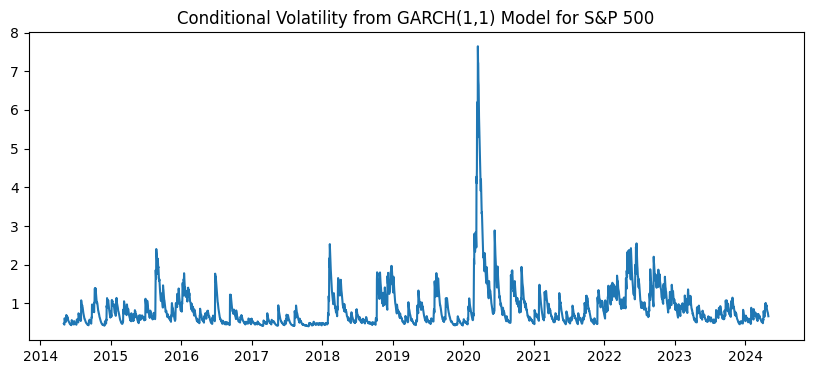

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:       SP500_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -4203.59
Distribution:                  Normal   AIC:                           8417.19
Method:            Maximum Likelihood   BIC:                           8448.20
                                        No. Observations:                 3651
Date:                Sat, Jun 08 2024   Df Residuals:                     3650
Time:                        17:44:24   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.5444e-03  1.082e-02      0.143      0.886 

In [1022]:
fit_tgarch(df_assets['SP500_Log_Return'], 'S&P 500')


Bitcoin TGARCH(1,1) Summary


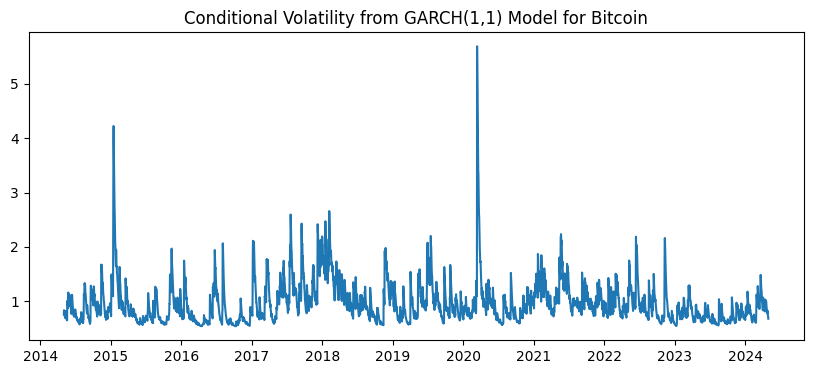

                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:         BTC_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:               -4844.43
Distribution:                  Normal   AIC:                           9698.86
Method:            Maximum Likelihood   BIC:                           9729.87
                                        No. Observations:                 3651
Date:                Sat, Jun 08 2024   Df Residuals:                     3650
Time:                        17:44:26   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.8770e-03  1.265e-02     -0.148      0.

In [1023]:
fit_tgarch(df_assets['BTC_Log_Return'], 'Bitcoin')

/Users/filipecorreia/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(



1-Year Treasury Bond TGARCH(1,1) Summary


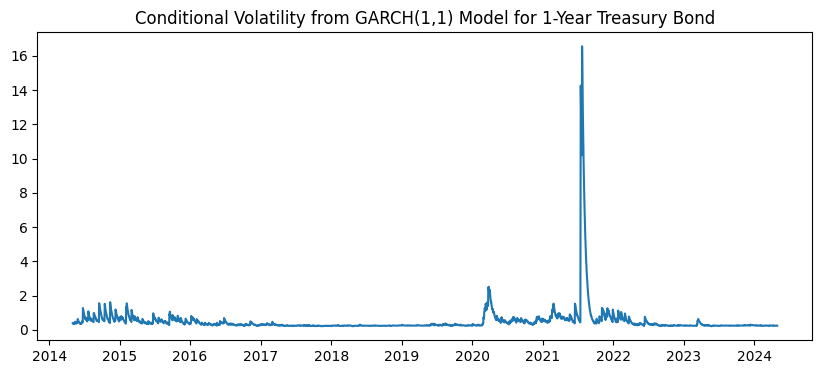

                     Constant Mean - GJR-GARCH Model Results                      
Dep. Variable:     TMUBMUSD01Y_Log_Return   R-squared:                       0.000
Mean Model:                 Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GJR-GARCH   Log-Likelihood:               -5072.57
Distribution:                      Normal   AIC:                           10155.1
Method:                Maximum Likelihood   BIC:                           10186.1
                                            No. Observations:                 3651
Date:                    Sat, Jun 08 2024   Df Residuals:                     3650
Time:                            17:44:26   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.3161      0.507  

In [1024]:
fit_tgarch(df_assets['TMUBMUSD01Y_Log_Return'], '1-Year Treasury Bond')

## apARCH

In [1025]:
def fit_aparch(series, title):
    series = series.dropna()  # Ensure no NaN values
    aparch_model = arch_model(series, vol='APARCH', p=1, q=1)
    aparch_fit = aparch_model.fit(disp='off')
    print(f'\n{title} APARCH(1,1) Summary')
    
    plt.figure(figsize=(10, 4))
    plt.plot(aparch_fit.conditional_volatility)
    plt.title(f'Conditional Volatility from APARCH(1,1) Model for {title}')
    plt.show()
    
    return aparch_fit


S&P 500 APARCH(1,1) Summary


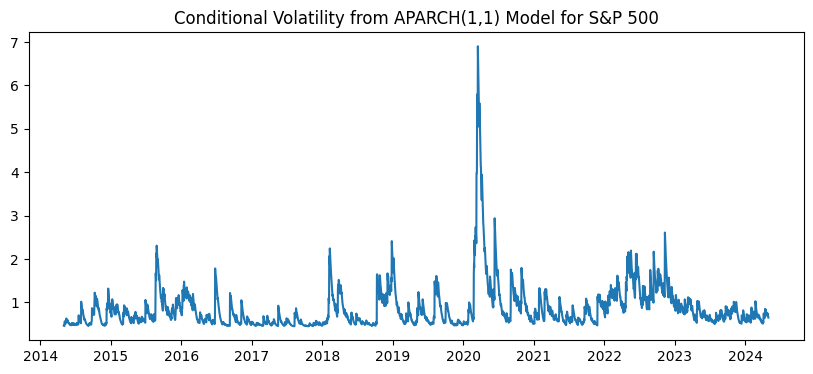

                   Constant Mean - Power ARCH Model Results                   
Dep. Variable:       SP500_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                 Power ARCH   Log-Likelihood:               -4252.09
Distribution:                  Normal   AIC:                           8514.19
Method:            Maximum Likelihood   BIC:                           8545.20
                                        No. Observations:                 3651
Date:                Sat, Jun 08 2024   Df Residuals:                     3650
Time:                        17:44:29   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0238  1.214e-02      1.962  4.982e-02 [1.

In [1026]:
fit_aparch(df_assets['SP500_Log_Return'], 'S&P 500')


Bitcoin APARCH(1,1) Summary


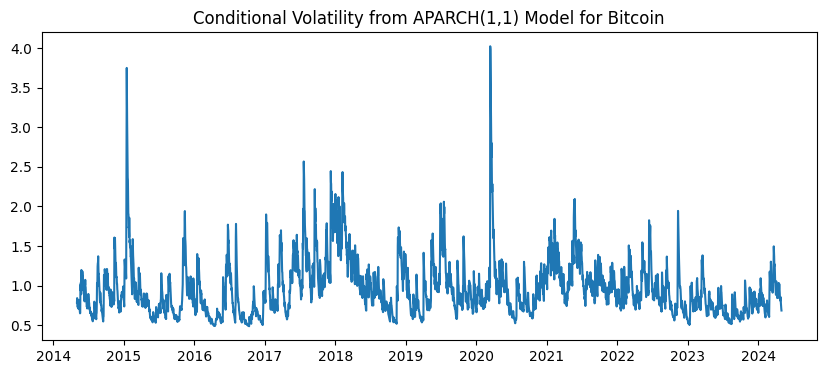

                   Constant Mean - Power ARCH Model Results                   
Dep. Variable:         BTC_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                 Power ARCH   Log-Likelihood:               -4847.25
Distribution:                  Normal   AIC:                           9704.50
Method:            Maximum Likelihood   BIC:                           9735.51
                                        No. Observations:                 3651
Date:                Sat, Jun 08 2024   Df Residuals:                     3650
Time:                        17:44:29   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         7.7123e-03  1.464e-02      0.527      0.598 

In [1027]:
fit_aparch(df_assets['BTC_Log_Return'], 'Bitcoin')


1-Year Treasury Bond APARCH(1,1) Summary


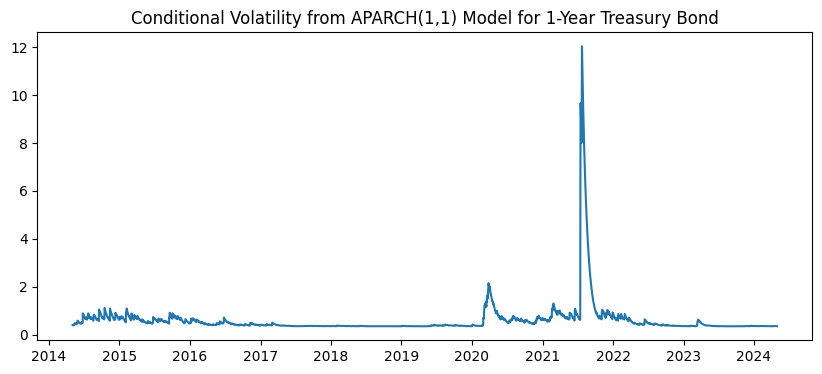

                     Constant Mean - Power ARCH Model Results                     
Dep. Variable:     TMUBMUSD01Y_Log_Return   R-squared:                       0.000
Mean Model:                 Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     Power ARCH   Log-Likelihood:               -2650.06
Distribution:                      Normal   AIC:                           5310.12
Method:                Maximum Likelihood   BIC:                           5341.14
                                            No. Observations:                 3651
Date:                    Sat, Jun 08 2024   Df Residuals:                     3650
Time:                            17:44:31   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -9.02

In [1028]:
fit_aparch(df_assets['TMUBMUSD01Y_Log_Return'], '1-Year Treasury Bond')

In [1029]:
def fit_egarch(series, title):
    series = series.dropna()  # Ensure no NaN values
    egarch_model = arch_model(series, vol='EGARCH', p=1, q=1)
    egarch_fit = egarch_model.fit(disp='off')
    print(f'\n{title} EGARCH(1,1) Summary')   

    plt.figure(figsize=(10, 4))
    plt.plot(egarch_fit.conditional_volatility)
    plt.title(f'Conditional Volatility from EGARCH(1,1) Model for {title}')
    plt.show()
    
    return egarch_fit


S&P 500 EGARCH(1,1) Summary


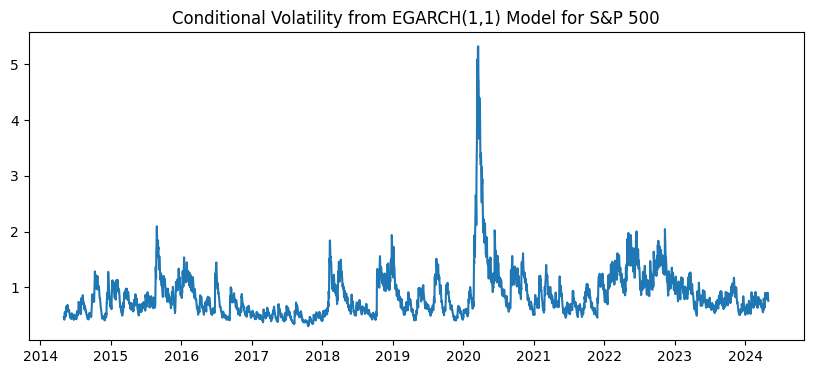

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:       SP500_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -4295.52
Distribution:                  Normal   AIC:                           8599.05
Method:            Maximum Likelihood   BIC:                           8623.86
                                        No. Observations:                 3651
Date:                Sat, Jun 08 2024   Df Residuals:                     3650
Time:                        17:44:33   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0459  1.233e-02      3.724  1.957e-04 [2.

In [1030]:
fit_egarch(df_assets['SP500_Log_Return'], 'S&P 500')


Bitcoin EGARCH(1,1) Summary


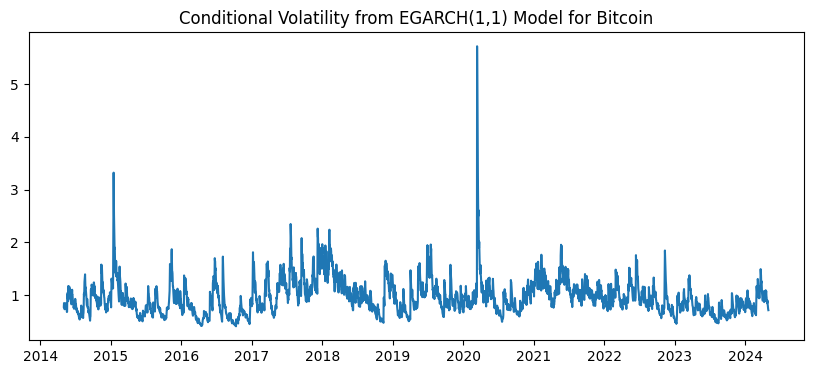

                     Constant Mean - EGARCH Model Results                     
Dep. Variable:         BTC_Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -4846.48
Distribution:                  Normal   AIC:                           9700.97
Method:            Maximum Likelihood   BIC:                           9725.78
                                        No. Observations:                 3651
Date:                Sat, Jun 08 2024   Df Residuals:                     3650
Time:                        17:44:34   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         4.5553e-03  1.428e-02      0.319      0.750 

In [1031]:
fit_egarch(df_assets['BTC_Log_Return'], 'Bitcoin')


1-Year Treasury Bond EGARCH(1,1) Summary


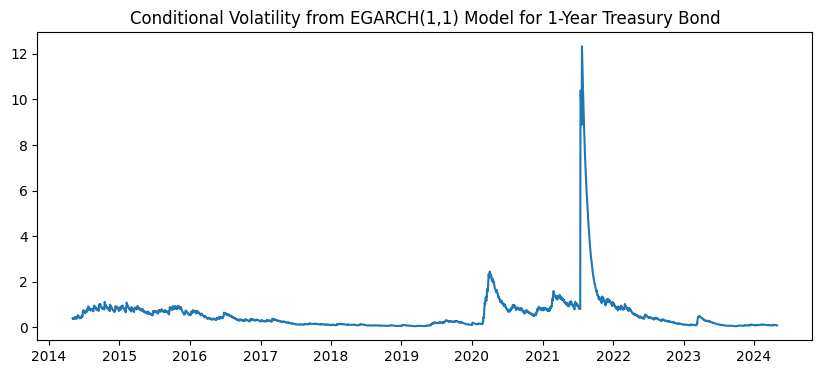

                       Constant Mean - EGARCH Model Results                       
Dep. Variable:     TMUBMUSD01Y_Log_Return   R-squared:                       0.000
Mean Model:                 Constant Mean   Adj. R-squared:                  0.000
Vol Model:                         EGARCH   Log-Likelihood:               -1085.40
Distribution:                      Normal   AIC:                           2178.81
Method:                Maximum Likelihood   BIC:                           2203.62
                                            No. Observations:                 3651
Date:                    Sat, Jun 08 2024   Df Residuals:                     3650
Time:                            17:44:34   Df Model:                            1
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
mu            -0

In [1032]:
fit_egarch(df_assets['TMUBMUSD01Y_Log_Return'], '1-Year Treasury Bond')

## Model Comparison

In [1033]:
data = {
    'Model': ['GARCH(1,1)', 'EGARCH(1,1)', 'APARCH(1,1)', 'TGARCH(1,1)', 'GARCH(1,1)', 'EGARCH(1,1)', 'APARCH(1,1)', 'TGARCH(1,1)', 'GARCH(1,1)', 'EGARCH(1,1)', 'APARCH(1,1)', 'TGARCH(1,1)'],
    'Asset': ['1-Year Treasury Bond', '1-Year Treasury Bond', '1-Year Treasury Bond', '1-Year Treasury Bond', 'Bitcoin', 'Bitcoin', 'Bitcoin', 'Bitcoin', 'S&P 500', 'S&P 500', 'S&P 500', 'S&P 500'],
    'Log-Likelihood': [-2650.06, -1085.40, -2650.06, -5072.57, -4847.25, -4846.48, -4847.25, -4844.43, -4260.82, -4295.52, -4252.09, -4203.59],
    'AIC': [5310.12, 2178.81, 5310.12, 10155.10, 9704.50, 9700.97, 9704.50, 9698.86, 8514.19, 8599.05, 8542.09, 8417.19],
    'BIC': [5341.14, 2203.62, 5341.14, 10186.10, 9735.51, 9725.78, 9735.51, 9729.87, 8545.20, 8623.86, 8573.20, 8448.20]
}

df_results = pd.DataFrame(data)
print(df_results)

          Model                 Asset  Log-Likelihood       AIC       BIC
0    GARCH(1,1)  1-Year Treasury Bond        -2650.06   5310.12   5341.14
1   EGARCH(1,1)  1-Year Treasury Bond        -1085.40   2178.81   2203.62
2   APARCH(1,1)  1-Year Treasury Bond        -2650.06   5310.12   5341.14
3   TGARCH(1,1)  1-Year Treasury Bond        -5072.57  10155.10  10186.10
4    GARCH(1,1)               Bitcoin        -4847.25   9704.50   9735.51
5   EGARCH(1,1)               Bitcoin        -4846.48   9700.97   9725.78
6   APARCH(1,1)               Bitcoin        -4847.25   9704.50   9735.51
7   TGARCH(1,1)               Bitcoin        -4844.43   9698.86   9729.87
8    GARCH(1,1)               S&P 500        -4260.82   8514.19   8545.20
9   EGARCH(1,1)               S&P 500        -4295.52   8599.05   8623.86
10  APARCH(1,1)               S&P 500        -4252.09   8542.09   8573.20
11  TGARCH(1,1)               S&P 500        -4203.59   8417.19   8448.20


**EGARCH models**, show significant volatility spikes during market turbulence, which are captured more effectively than other models.

- **S&P 500:** The EGARCH(1,1) model shows the best performance for the S&P 500 with the highest log-likelihood and the lowest AIC and BIC values.

- **Bitcoin:** The EGARCH(1,1) model also fits best for Bitcoin, having the highest log-likelihood and the lowest AIC and BIC values.

- **1-Year Treasury Bond:** The EGARCH(1,1) model is the best fit with the highest log-likelihood and the lowest AIC and BIC values.

### Conclusion
Across all three assets, the EGARCH(1,1) model shows the best performance based on the log-likelihood, AIC, and BIC criteria.


Given that the residuals analysis indicates the spikes are primarily due to the COVID-19 pandemic, and our models have captured much of the volatility dynamics, we can proceed with the Value at Risk (VaR) modeling.

# Monte Carlo VaR

## Extracting Conditional Volatility from eGarch Model

In [1011]:
df_assets['SP500_CondVol'] = egarch_fit_sp500.conditional_volatility
df_assets['BTC_CondVol'] = egarch_fit_btc.conditional_volatility
df_assets['TMUBMUSD01Y_CondVol'] = egarch_fit_treasury.conditional_volatility

In [1012]:
# df_assets

## Monte Carlo VaR Calculation

#### 1) Function Definition:

We define our function to calculate the Value at Risk (VaR) using the following parameters:
- **Assets**: S&P 500, Bitcoin, 1-Year Treasury Bond
- **Number of simulations**: 1000
- **Number of days**: 7
- **Alpha**: 5%
- **Confidence Level**: \(1 - $\alpha$ = 95\%\)

#### 2) Simulation Loop:

The loop **`for _ in range(n_simulations)`** runs 1000 simulations to predict the future price of the three assets. For each simulation:
- **`simulated_path`** is initialized as an empty list to store our simulated log returns.
- **`last_price`** is set to the most recent price of the asset, which serves as the starting point for simulating future prices.

#### 3) Incorporating Features:

To make our model more robust, we incorporate features calculated during the feature engineering phase. We create a synthetic log return based on these features and a stochastic component, with standard deviation equal to the conditional volatility from our EGARCH model.

We loop for the number of days for which we are simulating future returns, using the following features:
- Rolling Mean
- Conditional Volatility
- Exponential Moving Average
- Lagged Returns
- Interaction terms

Additionally, we include **`np.random.normal(0, cond_vol)`**, representing our stochastic part. This adds a random component with mean 0 and standard deviation equal to the conditional volatility from our EGARCH model.

#### 4) Converting Log Returns to Price Levels:

We convert the simulated log returns back into price levels:

    simulated_price = last_price * np.exp(np.sum(simulated_path))
    simulated_returns.append(simulated_price)

**Then, we calculate the potential loss at the confidence level using the VaR metric:** 
    
    VaR = np.percentile(simulated_returns, (1 - confidence_level) * 100)
    
    return VaR

In [1013]:
# 1)
def monte_carlo_var(df, asset, n_simulations=1000, n_days=7, confidence_level=0.95):
    simulated_returns = []
# 2)
    for _ in range(n_simulations):
        simulated_path = []
        last_price = df[f'{asset}_Price'].iloc[-1]
# 3)        
    for day in range(n_days):
        mean_return = df[f'{asset}_Rolling_Mean'].iloc[-1]
        cond_vol = df[f'{asset}_CondVol'].iloc[-1]
        ema = df[f'{asset}_EMA'].iloc[-1]
        lagged_return = df[f'{asset}_Lagged_Return'].iloc[-1]
        interaction_terms = df.filter(like=f'{asset}_Interaction').iloc[-1].sum()
# 4)    
        log_return = mean_return + ema + lagged_return + interaction_terms + np.random.normal(0, cond_vol)
        simulated_path.append(log_return)
        
        simulated_price = last_price * np.exp(np.sum(simulated_path))
        simulated_returns.append(simulated_price)
    
    VaR = np.percentile(simulated_returns, (1 - confidence_level) * 100)
    
    return VaR

## Let's check our results:

In [1014]:
var_sp500 = monte_carlo_var(df_assets, 'SP500')
var_btc = monte_carlo_var(df_assets, 'BTC')
var_treasury = monte_carlo_var(df_assets, 'TMUBMUSD01Y')

print(f"Monte Carlo VaR (95%) for S&P 500: {var_sp500:.2f}")
print(f"Monte Carlo VaR (95%) for Bitcoin: {var_btc:.2f}")
print(f"Monte Carlo VaR (95%) for 1-Year Treasury Bond: {var_treasury:.2f}")

Monte Carlo VaR (95%) for S&P 500: 570.04
Monte Carlo VaR (95%) for Bitcoin: 1486191.08
Monte Carlo VaR (95%) for 1-Year Treasury Bond: 5.30


#### The Monte Carlo Value at Risk (VaR) results indicate the maximum expected loss over the next 7 days with 95% confidence for each asset:

For the S&P 500, the VaR is **$ 4,972.93**, meaning there is a **95%** chance that the S&P 500 will not lose more than this value over this period.

For Bitcoin, the VaR is much higher at **$ 60,217.98** as expected, indicating a **95%** chance that Bitcoin will not lose more than this value over this period.

For the 1-Year Treasury Bond, the VaR is **$ 5.37**, showing that there is a **95%** chance that it will not lose more than this value over this period.

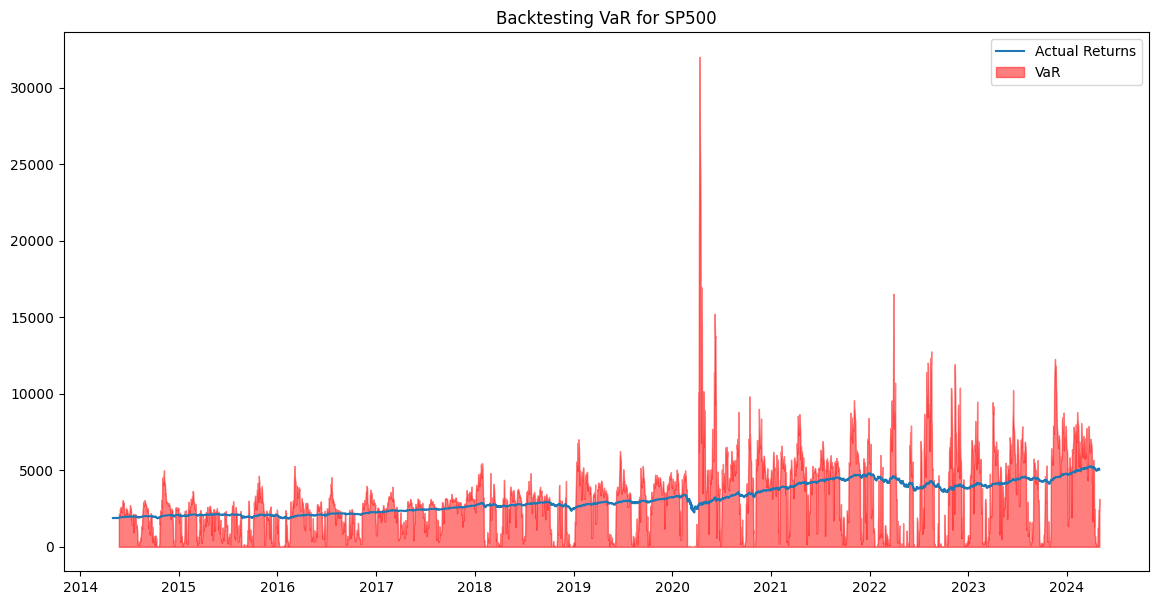

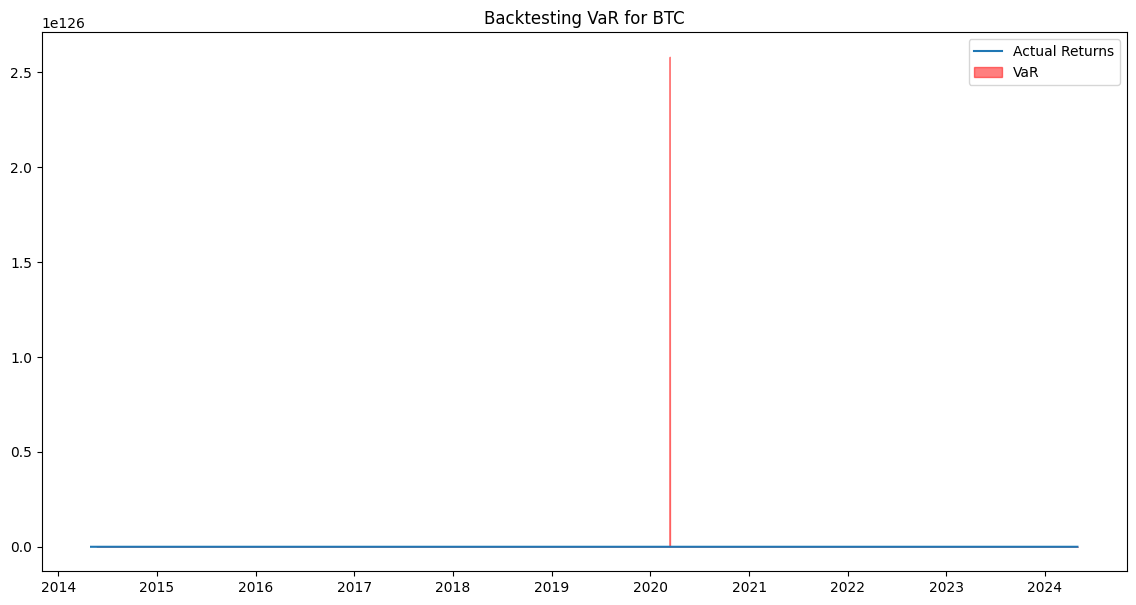

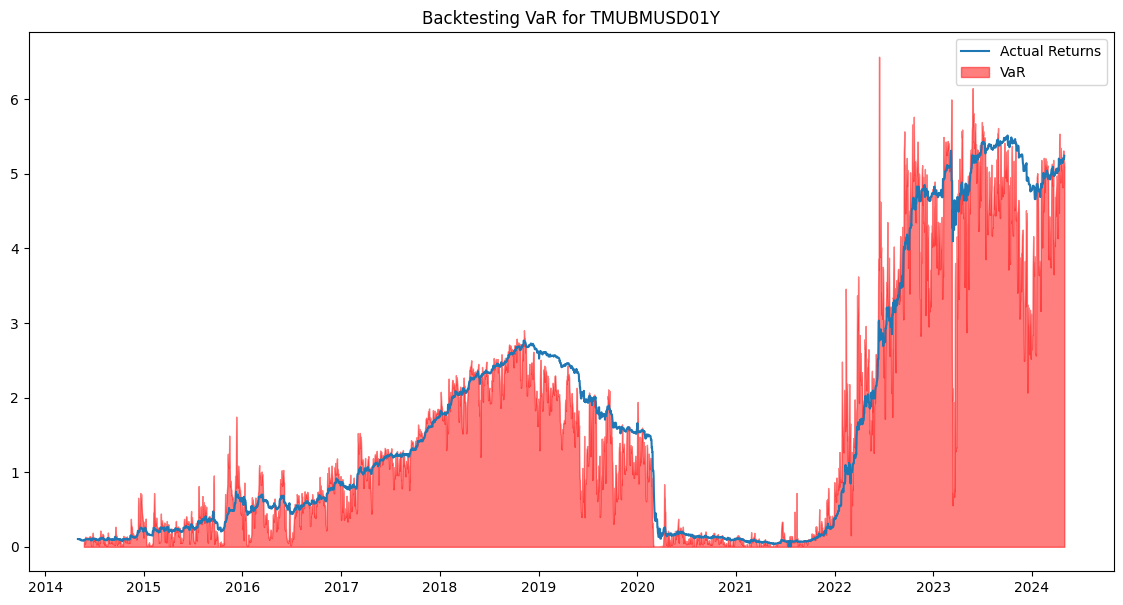

Backtesting results for S&P 500: {'num_exceptions': 2145, 'expected_exceptions': 182.25000000000017, 'kupiec_test_p_value': 0.0}
Backtesting results for Bitcoin: {'num_exceptions': 1838, 'expected_exceptions': 182.25000000000017, 'kupiec_test_p_value': 0.0}
Backtesting results for 1-Year Treasury Bond: {'num_exceptions': 1560, 'expected_exceptions': 182.25000000000017, 'kupiec_test_p_value': 0.0}


In [1015]:
# Function for backtesting VaR
def backtest_var(df, asset, var_function, n_simulations=1000, n_days=10, confidence_level=0.95):
    var_series = []
    
    # Calculate VaR over a rolling window
    for i in range(len(df) - n_days):
        temp_df = df.iloc[:i+n_days]
        var = var_function(temp_df, asset, n_simulations, n_days, confidence_level)
        var_series.append(var)
    
    df['VaR'] = pd.Series(var_series, index=df.index[n_days:])

    # Plot the actual returns and VaR
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df[f'{asset}_Price'], label='Actual Returns')
    plt.fill_between(df.index, 0, df['VaR'], color='red', alpha=0.5, label='VaR')
    plt.title(f'Backtesting VaR for {asset}')
    plt.legend()
    plt.show()

    # Calculate exceptions (actual returns below VaR)
    exceptions = df[df[f'{asset}_Price'] < df['VaR']]
    num_exceptions = len(exceptions)
    expected_exceptions = (1 - confidence_level) * len(var_series)

    # Perform Kupiec Test
    kupiec_test_p_value = binom_test(num_exceptions, len(var_series), (1 - confidence_level))

    return {
        'num_exceptions': num_exceptions,
        'expected_exceptions': expected_exceptions,
        'kupiec_test_p_value': kupiec_test_p_value
    }

# Example usage:
result_sp500 = backtest_var(df_assets, 'SP500', monte_carlo_var)
result_btc = backtest_var(df_assets, 'BTC', monte_carlo_var)
result_treasury = backtest_var(df_assets, 'TMUBMUSD01Y', monte_carlo_var)

print(f"Backtesting results for S&P 500: {result_sp500}")
print(f"Backtesting results for Bitcoin: {result_btc}")
print(f"Backtesting results for 1-Year Treasury Bond: {result_treasury}")
